## Проект: Предсказание судьбы стартапов

Нам предстоит работать с псевдо-реальными (реальные данные в которые добавлена синтетическая составляющая) данными о стартапах, функционировавших в период с 1970 по 2018 годы, и предсказать, какие из них закроются.

Метрикой в этом соревновании является F1-Score.

<br>

Датасет состоит из двух файлов: 
- тренировочный набор (около 53к записей)
- тестовый набор (около 13к записей). 

Тренировочный набор содержит целевой признак status (закрылся стартап или продолжает действовать). 
Временной период - '1970-01-01' по '2018-01-01'. 
Дата формирования выгрузки - '2018-01-01'

Описание полей данных:
- <b>name</b> - Название стартапа
- <b>category_list</b> - Список категорий, к которым относится стартап
- <b>funding_total_usd</b> - Общая сумма финансирования в USD
- <b>status</b> - Статус стартапа (закрыт или действующий)
- <b>country_code</b> - Код страны
- <b>state_code</b> - Код штата
- <b>region</b> - Регион
- <b>city</b> - Город
- <b>funding_rounds</b> - Количество раундов финансирования
- <b>founded_at</b> - Дата основания
- <b>first_funding_at</b> - Дата первого раунда финансирования
- <b>last_funding_at</b> - Дата последнего раунда финансирования
- <b>closed_at</b> - Дата закрытия стартапа (если применимо)
- <b>lifetime</b> - Время существования стартапа в днях



<br>
В ходе работы выполним несколько шагов:
<ol style="list-style-type: none">
<li><a href='#section1'>1. Загрузка и разведочный анализ</a>.</li>
Прочитаем данные, посмотрим на количество данных, количество пропущенных значений и формат представленных данных. Посмотрим, соответствуют ли они описанию задачи и стандартам оформления данных.
Проведем статистический анализ всех признаков. Построим графики для каждого признака. Посмотрим есть ли выбросы в данных. 

<li><a href='#section2'>2. Предобработка данных и генерация новых синтетических признаков</a>.</li>
Поработаем со столбцами, попробуем избавиться от пропущенных значений если они есть, проверим наличие дубликатов.
Разработаем новые признаки.  

<li><a href='#section3'>3. Проверка на мультиколлинеарность</a>.</li>
Посмотрим как данные связаны между собой и целевой переменной. На сонове это сделаем отбор набора обучающих признаков.

<li><a href='#section4'>4. Выбор и обучение моделей</a>.</li>
выберем и обучим модель. Для полученной модели сделаем оценку качества с использованием метрики f1.

<li><a href='#section5'>5. Оценка качества предсказания лучшей модели</a>.</li>
Для полученной модели сделаем оценку качества с использованием метрик f1 на итоговой выборке и сохраним результат.
    
<li><a href='#section6'>6. Итоговый вывод</a></li>

</ol>

#### Загрузка необходимых библиотек

In [657]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost as cb
from joblib import dump, load

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC



from sklearn.preprocessing import (PolynomialFeatures, StandardScaler, 
                                   MinMaxScaler, OneHotEncoder, 
                                   OrdinalEncoder, LabelEncoder)
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             recall_score, precision_score, accuracy_score,
                             roc_auc_score, f1_score, make_scorer)

from sklearn.inspection import permutation_importance


import phik
from phik.report import plot_correlation_matrix
# import shap
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

import os
import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid", font_scale=1)
pd.options.display.float_format = '{:_.2f}'.format

RANDOM_STATE = 42
TEST_SIZE = 0.15

# styles = [dict(selector="caption", props=[("text-align", "zero"),("font-size", "130%"),("font-weight", "bold")])]

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

#### Функции для отображение данных

In [372]:

def bar_plot_func_comp(df, col, num_col=10, hu=None, col_name=None, year=False):
    plt.subplots(figsize=(6, 7))
    if year:
        order_sort = df[col].value_counts().sort_index(key=lambda x: x, ascending=False).index[:num_col]
    else:
        order_sort = df[col].value_counts().index[:num_col]
        
    
    ax = sns.countplot(data=df,  
                     y=col,
                     edgecolor='black',
                     width=0.85,
                     alpha = 0.75,
                     linewidth=1,
                     # gap=0.25,
                     hue=hu,
                     # orient='h',
                     order=order_sort
                    )
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i], fmt='%.0f', padding = 5, label_type='edge', color='black', size = 10);

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=0)
    ax.set_xlim(0,df[col].value_counts().values.max()*1.20)

    ax.set_xlabel('кол-во', fontsize=12, fontweight="bold")
    ax.set_ylabel('категория', fontsize=12, fontweight="bold")
    ax.set_title(col.upper(), fontsize=12, fontweight="bold")
    ax.legend(fontsize=14, loc=4)  



# def bar_plor_func(dt, x_name, y_name, title_name=None, num_col=10):
#     plt.subplots(figsize=(16, 5))
#     ax = sns.barplot(data=dt,
#                      errorbar=None,
#                      edgecolor='black',
#                      width=0.7,
#                      alpha = 0.75,
#                      linewidth=1,
#                      orient='v',
#                      # gap=0.2,
#                      order=dt.index[:num_col]
#                     )
#     for i in range(len(ax.containers)):
#         ax.bar_label(ax.containers[i], fmt='%.0f', padding=5, label_type='edge', color='black', size = 11, rotation=90);
#     ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
#     ax.set_ylim(0,dt.values.max()*1.3)
#     # ax.set_title(f'Корреляция целевого признака')
#     ax.set_xlabel(x_name, fontsize=10, fontweight="bold")
#     ax.set_ylabel(y_name, fontsize=10, fontweight="bold")
#     if title_name:
#         ax.set_title(title_name.upper(), fontsize=10, fontweight="bold")

        


def bar_plor_func(dt, x_name, y_name, title_name=None, num_col=10):
    plt.subplots(figsize=(16, 5))
    dt = pd.DataFrame(zip(dt.index, dt.values), columns=['признак','значение'])
    ax = sns.barplot(data=dt,
                     x='признак',
                     y='значение',
                     errorbar=None,
                     edgecolor='black',
                     width=0.7,
                     alpha = 0.75,
                     linewidth=1,
                     # orient='v',
                     # gap=0.2,
                     order=dt['признак'][:num_col]
                    )
    for i in range(len(ax.containers)):
        ax.bar_label(ax.containers[i], fmt='%.0f', padding=5, label_type='edge', color='black', size = 11, rotation=90);
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
    ax.set_ylim(0,dt['значение'].values.max()*1.3)
    # ax.set_title(f'Корреляция целевого признака')
    ax.set_xlabel(x_name, fontsize=10, fontweight="bold")
    ax.set_ylabel(y_name, fontsize=10, fontweight="bold")
    if title_name:
        ax.set_title(title_name.upper(), fontsize=10, fontweight="bold")    
        
        

def graph_num_plot(df, feature):

    mean = df[feature].mean()
    median = np.median(df[feature])

    fig, axes = plt.subplots(1,2, figsize=(12, 3))


    axes[0].set_title('sasasa')
    ax1 = sns.histplot(data=df, 
                x=feature, 
                color='orange',
                kde=True,
                alpha = 0.9,
                edgecolor='b', 
                linewidth=1,
                # stat='density',
                line_kws={'lw': 1},
                bins=25,
                ax=axes[0]
               )
    ax1.set_title(f'распределение')
    ax1.set_xlabel('')
    ax1.set_ylabel('Кол-во')
    ax1.lines[0].set_color('k')

    axes[0].axvline(mean, color='r', linewidth=2, linestyle='dashed', label=f'среднее - {mean:.4f}')
    axes[0].axvline(median, color='k', linewidth=2, label=f'медиана - {median:.4f}')

    ax2 = sns.boxplot(data=df, 
                x=feature, 
                color='orange', 
                ax=axes[1], 
                fliersize = 10,
                linewidth = 2,  # Lines width
                saturation = 0.95,
                width = 0.5,
                showmeans=True,
                meanline=True,
                meanprops={'color': 'r', 'ls': '--', 'lw': 3},
                # meanprops={'marker':'o',
                #            'markerfacecolor':'white', 
                #            'markeredgecolor':'black',
                #            'markersize':'8'}
                flierprops={'marker': 'o', 'markersize':5, 'markerfacecolor':'None'}
               )
    ax2.set_title(f'диаграмма размаха')
    ax2.set_xlabel('')
    fig.legend()
    fig.suptitle(feature.upper(), fontname="Comic Sans MS", fontsize=12, y=1.15, fontweight="bold")
    plt.show()

    
    
    
    
#Функция для построения графиков категориаль
def graph_cat_single_plot(df, fech, ax, ori='v', hue=None):
    
    if ori == 'v':
        axx = sns.countplot(data=df,
                                x=fech, 
                                order=df[fech].value_counts(dropna=False).index, 
                                saturation = 0.85,
                                # palette=pal,
                                hue=hue,
                                color='orange',
                                width=0.5,
                                orient='v',
                                edgecolor='b', 
                                linewidth=1,
                                ax=ax
                             )
        l = len(axx.patches)
        for n, p in enumerate(axx.patches):
            percentage = f'{p.get_height():,.0f}'
            width, height = p.get_width(),p.get_height()
            x=p.get_x()+width/2-0.1*((n+1)**0.7)
            y=p.get_y()+height+0.05*height
            ax.annotate(percentage,(x,y), fontsize=12, fontweight="bold")


        ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=0)
        ax.set_ylim(0,df[fech].value_counts().values.max()*1.30)
        # ax.set_title(f'Корреляция целевого признака')
        ax.set_xlabel('категория', fontsize=12, fontweight="bold")
        ax.set_ylabel('кол-во', fontsize=12, fontweight="bold")
        ax.set_title(fech.upper(), fontsize=12, fontweight="bold")
        
        
    else:
        axx = sns.countplot(data=df,
                        y=fech, 
                        order=df[fech].value_counts(dropna=False).index, 
                        saturation = 0.85,
                        # palette=pal,
                        hue=hue,
                        color='orange',
                        width=0.5,
                        edgecolor='b', 
                        linewidth=1,
                        ax=ax
                     )
        l = len(axx.patches)
        for n, p in enumerate(axx.patches):
            percentage = f'{p.get_width():,.0f}'
            width, height = p.get_width(),p.get_height()
            x=p.get_x()+width +0.05* width
            y=p.get_y()+height-0.1*((n+1)**0.1)
            ax.annotate(percentage,(x,y), fontsize=12, fontweight="bold")


        ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=35)
        ax.set_xlim(0,df[fech].value_counts().values.max()*1.30)
        # ax.set_title(f'Корреляция целевого признака')
        ax.set_ylabel('категория', fontsize=12, fontweight="bold")
        ax.set_xlabel('кол-во', fontsize=12, fontweight="bold")
        ax.set_title(fech.upper(), fontsize=12, fontweight="bold")
    

<a id='section_1'></a>

#### Функции для обработки данных

In [376]:
def calculus_lifetime(data):
    '''
    Функция для расчета жизни стартапа относительно точки выгрузки данных 2018 г.
    При расчете учитывается самая ранняя дата появления стартапа.
    
    Args:
        data: датасет с признаками, dataframe
    
    Returns:
        возвращает продолжительноть жизни стартапа, number.
    '''
    if data['closed_at'] is pd.NaT:
        if data['founded_at'] < data['first_funding_at']:
            return (pd.to_datetime(2018, format='%Y') - data['founded_at'])
        else:
            return (pd.to_datetime(2018, format='%Y') - data['first_funding_at'])
    else:
        if data['founded_at'] < data['first_funding_at']:
            return (data['closed_at'] - data['founded_at'])
        else:
            return (data['closed_at'] - data['first_funding_at'])


def preproces(data_prep, diction_country_code=None, diction_state_code=None, diction_category_list_one=None, train_flag=False):
    '''
    Функция для заполнения пропусков и добавления новых признаков.
    
    Args:
        data_prep: датасет с признаками, dataframe
    
    Returns:
        возвращает dataframe.
    '''

    data = data_prep.copy()

    data['category_list'] = data['category_list'].fillna('NaN')
    data['country_code'] = data['country_code'].fillna('USA')
    data['state_code'] = data['state_code'].fillna('CA')

    #признак - процент открытых стартапов по странам
    data['delta_2'] = (data['last_funding_at'] - data['first_funding_at']).dt.days
    
    #признак - дельта на один раунд <b>delta_one_round</b>
    data['delta_one_round'] = data['delta_2'] // data['funding_rounds']

    #признак - финаннсирование на один раунд <b>fund_one_round</b>
    data['fund_one_round'] = data['funding_total_usd'] / data['funding_rounds']
    
    #признак - процент открытых стартапов по странам
    
    if diction_country_code:
        data['persent_open'] = data['country_code'].map(diction_country_code)
    else:    
        diction_country_code = data[['country_code', 'status']].groupby('country_code').describe()['status']['mean'].round(2).to_dict()
        data['persent_open'] = data['country_code'].map(diction_country_code)

    if data['persent_open'].isna().sum():
        mediana = data.dropna(subset=['persent_open'])['persent_open'].median()
        data.loc[data['persent_open'].isna(), ['persent_open']] = mediana
    
    #признак - процент открытых стартапов по штатам
    if diction_state_code:
        data['code_persent_open'] = data['state_code'].map(diction_state_code)
    else:
        diction_state_code = data[['state_code', 'status']].groupby('state_code').describe()['status']['mean'].round(2).to_dict()
        data['code_persent_open'] = data['state_code'].map(diction_state_code)

    if data['code_persent_open'].isna().sum():
        mediana = data.dropna(subset=['code_persent_open'])['code_persent_open'].median()
        data.loc[data['code_persent_open'].isna(), ['code_persent_open']] = mediana

    dict_fund_country = data.dropna(subset=['fund_one_round'])
    dict_fund_country = dict_fund_country[['country_code', 'fund_one_round']].groupby('country_code').median().to_dict()['fund_one_round']
    
    
    mediana = data.dropna(subset=['fund_one_round'])['fund_one_round'].median()
    data['country_code'] = data['country_code'].fillna('other')
    
    country_names = data[data['funding_total_usd'].isna()]['country_code'].unique()

    
    #заполнение пропущенных значений в столбце финансирование на один раунд
    for i in country_names:
        try:
            data.loc[(data['fund_one_round'].isna()) & (data['country_code'] == i), ['fund_one_round']] = dict_fund_country[i]
        except:
            data.loc[(data['fund_one_round'].isna()) & (data['country_code'] == i), ['fund_one_round']] = mediana

    #заполнение пропущенных значений в столбце финансирование
    data['funding_total_usd'] = data['fund_one_round'] * data['funding_rounds']
    
    #признак - продолжительность жизни стартапа
    if train_flag:
        data['lifetime'] = data.apply(calculus_lifetime, axis=1).dt.days

    #признак - длина описания
    num_description = data['category_list'].str.lower().str.split('|', expand=True).applymap(lambda x: 1 if x != None else 0)
    data['categ_long_pers'] = 1 - num_description.sum(axis=1)/num_description.shape[1]

    
    all_category_list = []
    for i in data['category_list'].str.lower().str.split(r'|', expand=False).values:
        if type(i) != float:
            all_category_list.extend(i)

    #создадим столбец описания наиболее часто встречаемых категорий, выделим 50 категорий (n_categ)
    n_categ = 100
    data_ = pd.DataFrame(all_category_list, columns=['name'])
    data_ = data_.value_counts().head(num).reset_index().drop('count', axis=1)
    data_['rang'] = np.round(np.arange(num, 0, -1)/num, 2)
    all_category_dic = data_.set_index('name').to_dict()['rang']
            
    name_main_category = data_['name'].value_counts().index
    
    name_main_category_frame = []
    for i in data['category_list']:
        done = True
        if type(i) is not float:
            i = i.lower().split('|')
            for name in name_main_category:
                if name in i:
                    name_main_category_frame.append(name)
                    done = False
                    break
            if done:
                name_main_category_frame.append('other')
                done = True

        else:
            name_main_category_frame.append('other')
    
    data['category_list_one'] = name_main_category_frame

    data.loc[(data['category_list_one'] == 'nan'), 'category_list_one'] = 'software'

    data.loc[(data['category_list_one'] == 'enterprise software') | (data['category_list_one'] == 'hardware + software'), 'category_list_one'] = 'software'
    data.loc[(data['category_list_one'] == 'health and wellness') | (data['category_list_one'] == 'health diagnostics'), 'category_list_one'] = 'health care'
    data.loc[(data['category_list_one'] == 'digital media') | (data['category_list_one'] == 'social media'), 'category_list_one'] = 'media'
    data.loc[(data['category_list_one'] == 'curated web') | (data['category_list_one'] == 'web hosting'), 'category_list_one'] = 'web'
    data.loc[(data['category_list_one'] == 'big data analytics') | (data['category_list_one'] == 'big data'), 'category_list_one'] = 'big data'
    data.loc[(data['category_list_one'] == 'apps')| (data['category_list_one'] == 'mobile commerce')| 
                                            (data['category_list_one'] == 'iphone')
                                            | (data['category_list_one'] == 'android')
                                            | (data['category_list_one'] == 'ios'), 'category_list_one'] = 'mobile'


    

    #признак - частота встречаемости категории

    if diction_category_list_one:
        data['category_list_pers'] = data['category_list_one'].map(diction_category_list_one)
    else:  
        diction_category_list_one = data[['category_list_one', 'status']].groupby('category_list_one').describe().round(4)['status']['mean'].to_dict()
        data['category_list_pers'] = data['category_list_one'].map(diction_category_list_one)

    if data['category_list_pers'].isna().sum():
        # mediana = data.dropna(subset=['code_persent_open'])['code_persent_open'].median()
        index = data.loc[data['category_list_pers'].isna(), ['category_list_one']].index
        data.loc[index, ['category_list_pers']] = data.loc[(data['category_list_one'] == 'other'), ['category_list_pers']].mean().values[0]
        data.loc[index, ['category_list_one']] = 'other'
        
    data = data.sort_index(axis=1)
      
    return data, diction_country_code, diction_state_code, diction_category_list_one

def corr_plor_func(dataset, xlim, title_name):
    m = pd.DataFrame(zip(dataset.index, dataset.values), columns=['признак','значение']).sort_values('значение', ascending=False)
    fig, ax = plt.subplots(figsize=(8, 5))
    pal = sns.color_palette("Oranges_r", len(dataset))
    # sns.set_color_codes("muted")
    axx = sns.barplot(data=m, 
                      y='признак', 
                      x='значение', 
                      saturation = 0.9,
                      palette=pal
                      # width=0.75,

                     )
    for p in axx.patches:
        percentage = f'{p.get_width():,.3f}'
        width, height = p.get_width(),p.get_height()
        x=p.get_x()+width+0.02
        y=p.get_y()+height/2+0.1
        ax.annotate(percentage,(x,y), fontsize=11, fontweight="bold")
    ax.set_xlim(xlim[0], xlim[1])
    # ax.set_title(f'Корреляция целевого признака')
    ax.set_xlabel('Коэф. корреляции', fontsize=12, fontweight="bold")
    ax.set_ylabel('Признак', fontsize=12, fontweight="bold")
    ax.lines[0].set_color('k')
    fig.suptitle(title_name.upper(), fontname="Comic Sans MS", fontsize=12, fontweight="bold");

<a id='section1'></a>

### 1. Загрузка данных

Прочитаем данные, посмотрим на количество данных, количество пропущенных значений и формат представленных данных. Посмотрим, соответствуют ли они описанию задачи и стандартам оформления данных. При необходимости переименуем столбцы

Прочитаем наши данные

In [382]:
try:
    train = pd.read_csv('/datasets/kaggle_startups_train_28062024.csv')
    test = pd.read_csv('/datasets/kaggle_startups_test_28062024.csv')
    print('The file exists global')
except:
    train = pd.read_csv('kaggle_startups_train_28062024.csv')
    test = pd.read_csv('kaggle_startups_test_28062024.csv')
    print('The file exists local')

The file exists local


Посмотрим на обучающую выборку

In [385]:
display(train.sample(10))
train.shape

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
28736,Speakeasy Inc,Consulting,3_350_909.00,operating,USA,GA,Atlanta,Atlanta,2,1975-01-01,2013-08-02,2014-08-27,NaN
503,Zenops,Games,5_240_000.00,operating,FRA,A8,Paris,Courbevoie,2,2003-01-01,2005-01-01,2007-04-24,NaN
5096,Teleradiology Holdings Inc.,NaN,10_000_000.00,operating,USA,PA,Pittsburgh,Pittsburgh,1,2007-12-14,2009-04-17,2009-04-17,NaN
9181,LevelUp,Mobile|Payments,40_000_000.00,operating,USA,MA,Boston,Boston,3,2011-07-14,2010-01-01,2012-08-01,NaN
15962,Store Locator,Location Based Services|Search|Shopping,NaN,operating,CHE,2,Herisau,Herisau,1,2009-09-01,2009-09-01,2009-09-01,NaN
30503,Jobartis,Human Resources|Portals|Recruiting,206_380.36,operating,NaN,NaN,NaN,NaN,1,2013-07-07,2013-12-13,2013-12-13,NaN
843,Advanced Integration Technology,Aerospace|Industrial Automation|Service Providers,NaN,operating,USA,TX,Dallas,Plano,1,2013-10-05,2014-11-25,2014-11-25,NaN
31266,"VeloCloud, Inc.",Networking,21_000_000.00,operating,USA,CA,SF Bay Area,Mountain View,1,2012-01-01,2014-06-17,2014-06-17,NaN
40583,FeedVisor,E-Commerce|SaaS,7_700_000.00,operating,ISR,5,Tel Aviv,Tel Aviv,2,2011-03-01,2013-10-23,2014-08-26,NaN
13789,"Hipcricket, Inc.",Advertising,250_000.00,operating,USA,NY,New York City,New York,1,1999-01-01,2012-10-03,2012-10-03,NaN


(52516, 13)

Выведем информацию по выборке

In [387]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


В датасете представлены 13 столбцов: Кол-во строк равняется 52516. Форматы данных даты - столбцы <b>founded_at,  first_funding_at, last_funding_at </b> представлены неправильно. 
Столбец <b>closed_at</b> будет сильно коррелировать со столбцом status, в нем приведены даты закрытия стартапов. В некоторых столбцах много пропущенных значений. <br>

Сразу приведем формат данных столбцы <b>founded_at,  first_funding_at, last_funding_at, 'closed_at' </b> к правильному

In [391]:
train['founded_at'] = pd.to_datetime(train['founded_at'])
train['first_funding_at'] = pd.to_datetime(train['first_funding_at'])
train['last_funding_at'] = pd.to_datetime(train['last_funding_at'])
train['closed_at'] = pd.to_datetime(train['closed_at'],  errors="ignore")
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828_626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22_250_000.00,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


Посомтрим на процент пропущенных значений

In [393]:
styles = [dict(selector="caption", props=[("text-align", "center"),
                                          ("font-size", "110%"),
                                          ("font-weight", "bold"), 
                                          ("color","gray")])]
float_format = '{:_.2f}'.format
display(pd.DataFrame({'Кол-во пропущенных значений':train.isna().sum(), 'Процент пропущенных значений': (train.isna().mean().apply(lambda x: "{:,.0f}%".format(x*100)))}).style.\
        set_table_attributes("style='border:1px solid;font-size:14px;margin:14px;margin-left:12px'").\
        set_caption(f'Пропущенные значения по признакам').\
        set_table_styles(styles))

,Кол-во пропущенных значений,Процент пропущенных значений
name,1,0%
category_list,2465,5%
funding_total_usd,10069,19%
status,0,0%
country_code,5502,10%
state_code,6763,13%
region,6359,12%
city,6359,12%
funding_rounds,0,0%
founded_at,0,0%


Больше всего пропущенных значений, 91%, в столбце <b>closed_at</b>. На основе данного признака можно попробовать синтезировать новые. Как сам признак, с учетом его связи со status и большого количества пропусков, придется от него избавиться. В признаках <b>country_code, state_code, region, city</b> более 10% процентов значений. Данные признаки скорее всего также будут сильно коррелировать между собой. В признаке funding_total_usd - 19% пропущенных значений. Значения можно будет попроовать восстановить на основе мединых значений стартапов в тех же странах.

Посмотрим на столбец статуса, как распределены значения

In [397]:
train.status.value_counts()

status
operating    47599
closed        4917
Name: count, dtype: int64

Выборка несбалансирована. Количество закрытых стартапов в 10 раз меньше чем функционирующих. 

Так как признаки <b>country_code, state_code, region, city</b> должны сильно коррелировать проверим насколько возможно будет восстановить пропущенные значния. Для этого посмотрим насколько пропуски пересекаются по данным столбцам.

In [403]:
mask = (train['country_code'].isna()) & (train['state_code'].isna()) & (train['region'].isna()) &  (train['city'].isna())
train.loc[mask, ['city', 'region']].all(axis=1).sum() / train.shape[0] * 100

10.476807068322035

Процент пропуска сразу по всем четырем столбцам составляет 10%, что близко к значению пропуска для каждого столбца в отдельности. Делаем вывод - пропуски удут сразу по четырем признакам и восстановить так просто не получиться. Можно попробовать сделать предположение, что медианные занчения <b>funding_total_usd</b> для одних и тех же стран будут близки. Тогда сопоставить <b>funding_total_usd</b> со строками в которых пропуски и так востановить хотябы признак <b>country_code</b>

Посмотрим на признак <b>category_list</b>. В данном признаке представлено описание к каким категориям относится стартап.

In [407]:
train['category_list'].value_counts()

category_list
Software                                                                                  3207
Biotechnology                                                                             2905
E-Commerce                                                                                1064
Mobile                                                                                     920
Clean Technology                                                                           892
                                                                                          ... 
iPad|Reviews and Recommendations|Social Television|Software|Television|Video on Demand       1
Graphics|Software|Startups                                                                   1
Curated Web|File Sharing|Graphics|PaaS                                                       1
Cloud Computing|Cloud Data Services|Databases|IaaS|Services|Software|Virtualization          1
Online Rental|Parking|Price Comparis

В данной категории представлено 22105 уникальных значений. Необходимо уменьшить размерность данного признака. Это можно сделать за счет поиска и укрупнения близких категорий (наиболее встречаемых категорий). Так же можно попробовать векторизовать строки и за счет кластиризации выделить отдельные классы.

Для исследования наших данных сделаем отдельный датафрейм, что бы не внести изменения в исходный.

In [411]:
df = train.copy()
df = df.drop(['name', 'closed_at'], axis=1).dropna()
df['founded_at'] = df['founded_at'].dt.year
df['first_funding_at'] = df['first_funding_at'].dt.year
df['last_funding_at'] = df['last_funding_at'].dt.year

Посмотрим на распределение основных категорий в зависимости от признака "открытие/закрытие"

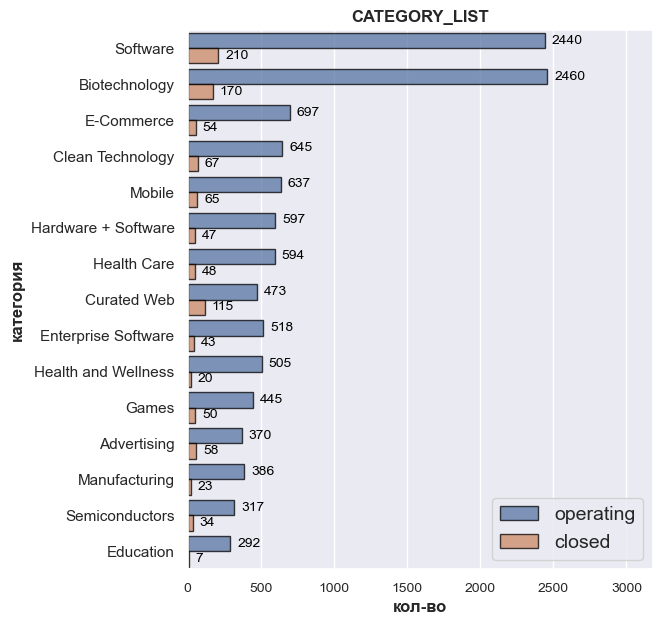

In [414]:
col='category_list'
bar_plot_func_comp(df=df, col=col, num_col=15, hu='status')

Наиболее часто встречаемая категория "software" и "biotechnology". После укрупнения классов баланс может немного поменяться.

Посмотрим на количество стартапов по странам <b>country_code</b>  в зависимости от закрытия. Выведем 10 основных категорий.

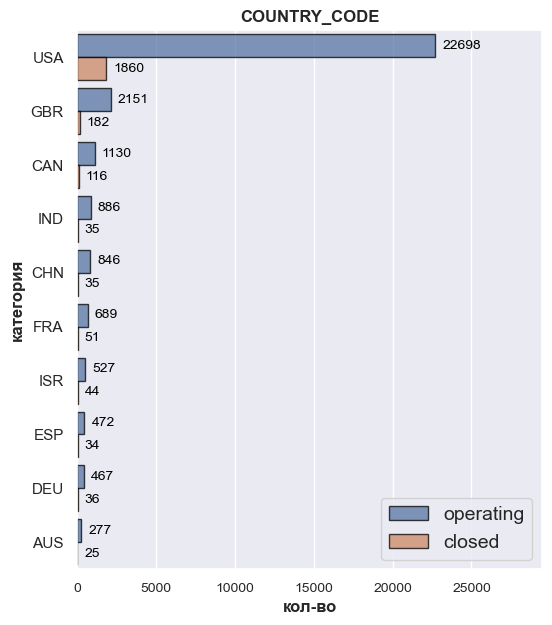

In [418]:
col='country_code'
bar_plot_func_comp(df=df, col=col, num_col=10, hu='status')

Больше всего стартапов в "USA". Все остальные категории сильно меньше. Тоже касается распределения по штатам, первыми идут штаты, которые относятся к "USA"

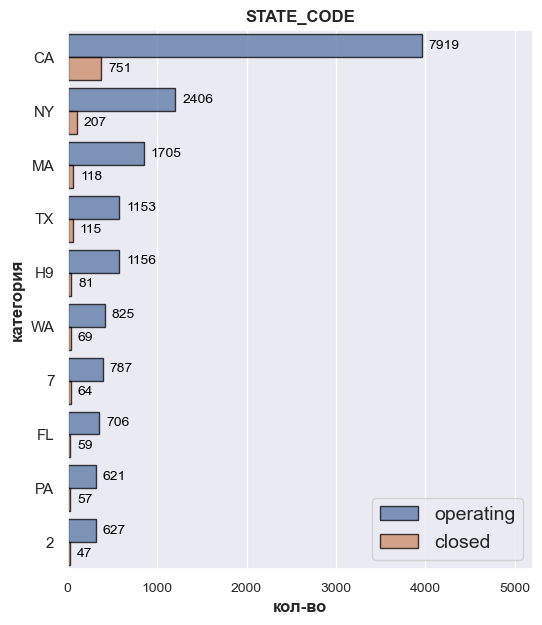

In [421]:
col='state_code'
bar_plot_func_comp(df=df, col=col, num_col=10, hu='status')

Посмотрим на распределение количества раундов. Больше всего стартапов у которых был один раунд инвестирования. Далее количество стартапов уменьшается с уменьшение количества раундов

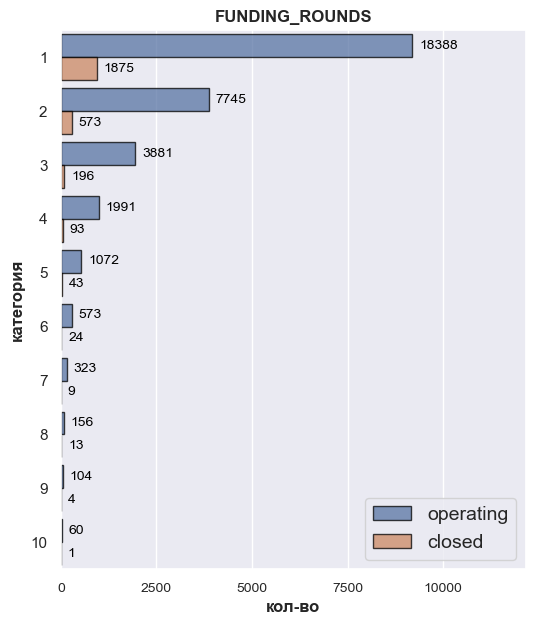

In [424]:
col='funding_rounds'
bar_plot_func_comp(df=df, col=col, num_col=10, hu='status')

Посмотрим кол-во появление стартапов по годам. Видно, что был почти до 80х количество стартапов не меняется. Потом в 80х происходит слабое увеличение числа числа. В 90х начинается ускоренный рост, которые достигает максмума 2012 году. После этого количество начинает резко уменьшатся. Учитывая что больше всего стартапов в США. То такой поведение можно попробовать связать с событиями происходящим там. Например с уровнем инфляции, он до 2015 он уменьшался и достиг значения 0.73%. Начиная с 2016 уровень инфляции стал более 2%.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


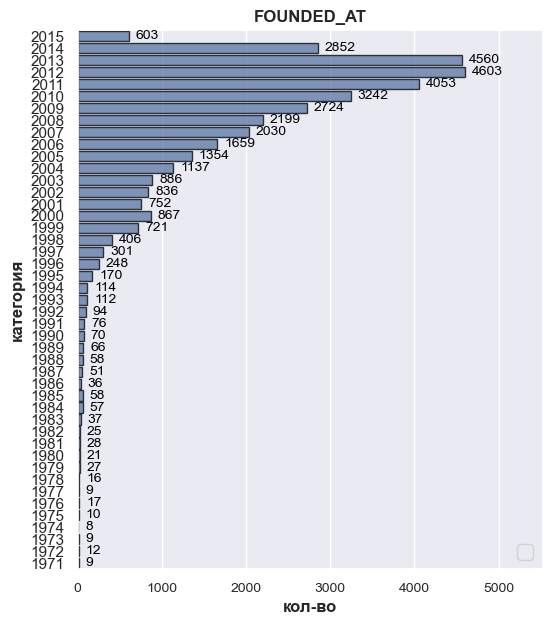

In [427]:
col='founded_at'
bar_plot_func_comp(df=df, col=col, num_col=50, year=True)

Посмотрим кол-во финансирования стартапов по годам. Сходий рост до 2014г, отсутствие данных после 2014г не позволяет проследить динамику далее.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


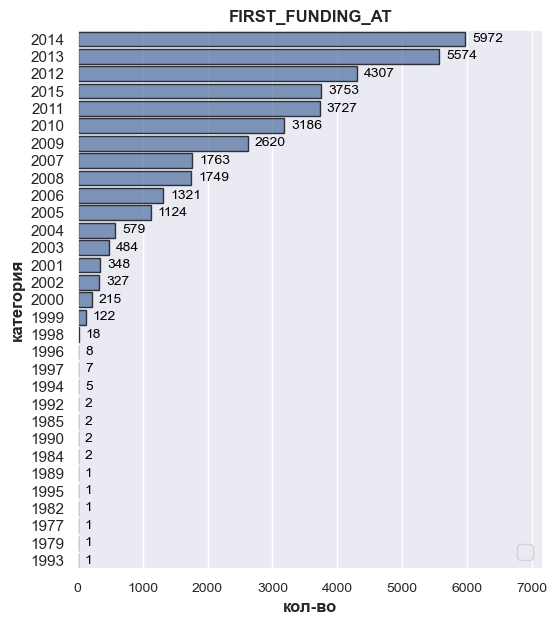

In [429]:
col='first_funding_at'
bar_plot_func_comp(df=df, col=col, num_col=50)

Данные по последниму этапу финансирования заканчиваются 2015г. До этого идет увеличение количества стартапов.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


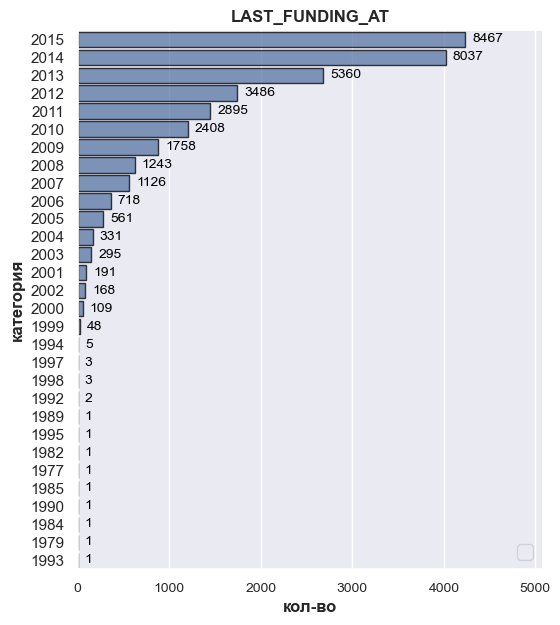

In [431]:
col='last_funding_at'
bar_plot_func_comp(df=df, col=col, num_col=50)

Для дальнейшего исследования переведем столбец <b>status</b> в числовой

In [434]:
mask = {'operating':1, 'closed': 0}
df['status'] = df['status'].map(mask)

Посмотрим на процент распределение количества незакрытых стартапов по странам. Для многих стран значение меняется не очень сильно, Но есть страны у которых процент закрытия достаточно большой (RUS, SLV, LIE, BLR). Во многих странах значение дотигает 100. Это может быть связано с недостаточной статистикой, мало стартапов в данных странах.

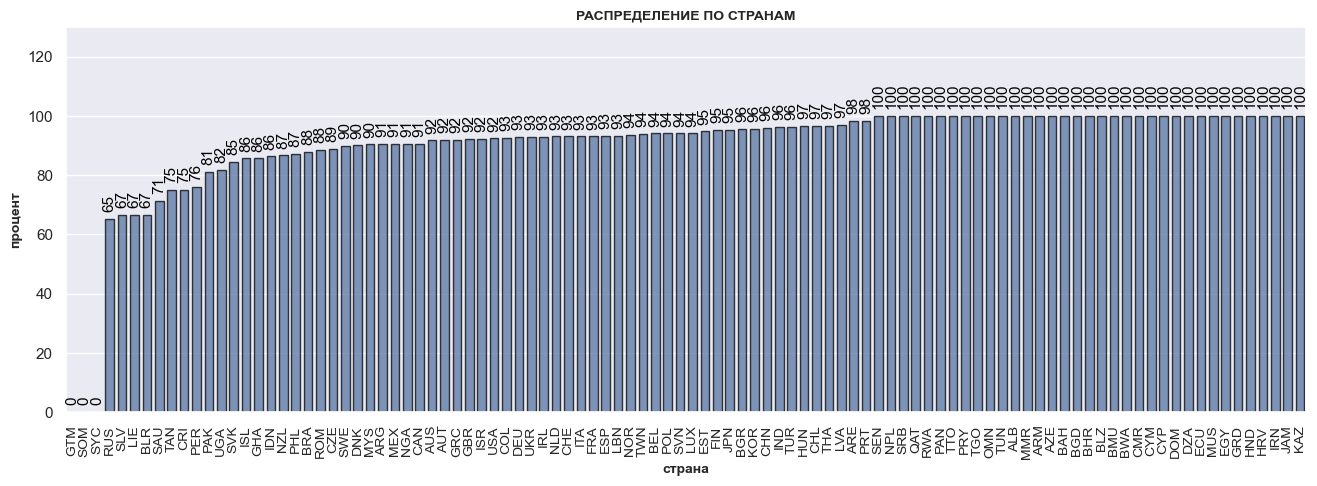

In [616]:
df_ = df[['country_code', 'status']].groupby('country_code').agg(['mean'])['status'].squeeze()*100
df_ = df_.sort_values()
bar_plor_func(df_, x_name = 'страна', y_name = 'процент', title_name='Распределение по странам', num_col=100)

Посмотрим на сумму финансирования по странам. Наибольшая сумма вложений в стартапы была в USA, что объясняется большим количеством стартапов в данной стране.

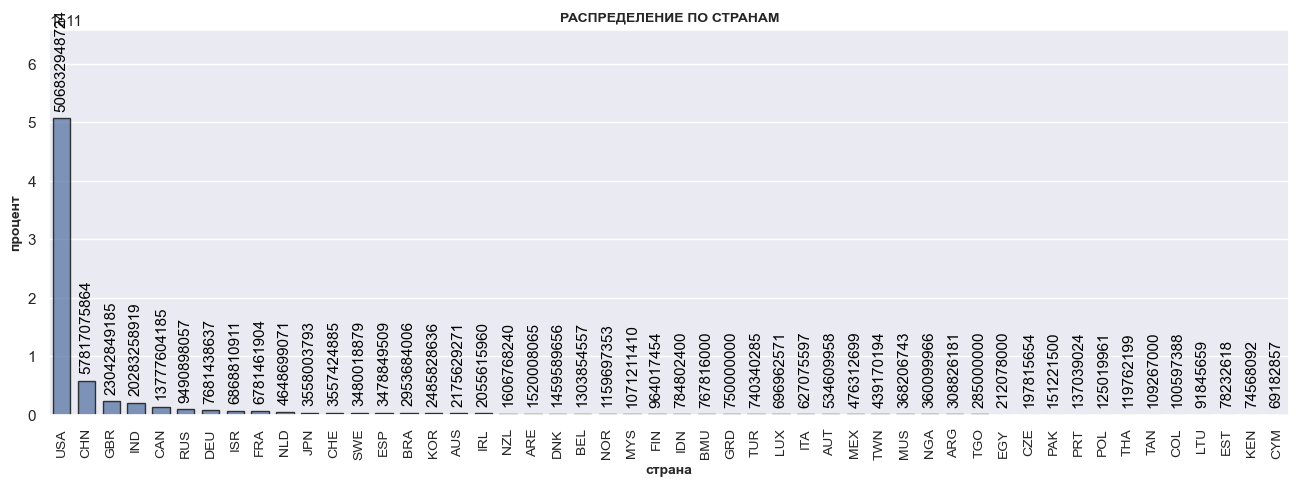

In [629]:
df_ = df[['country_code', 'funding_total_usd']].groupby('country_code').agg(['sum'])['funding_total_usd'].squeeze()
df_ = df_.sort_values(ascending=False)
bar_plor_func(df_, x_name = 'страна', y_name = 'процент', title_name='Распределение по странам', num_col=50)

Если смотреть медианный график по странам, то первыми идут страны "GRB", "TGO", что говорит о том, что в данных странах небольшое количество стартапов с большими суммами вливания. Впротивовес "USA" у которой большая сумма вливания, но при этом большое количество стартапов.

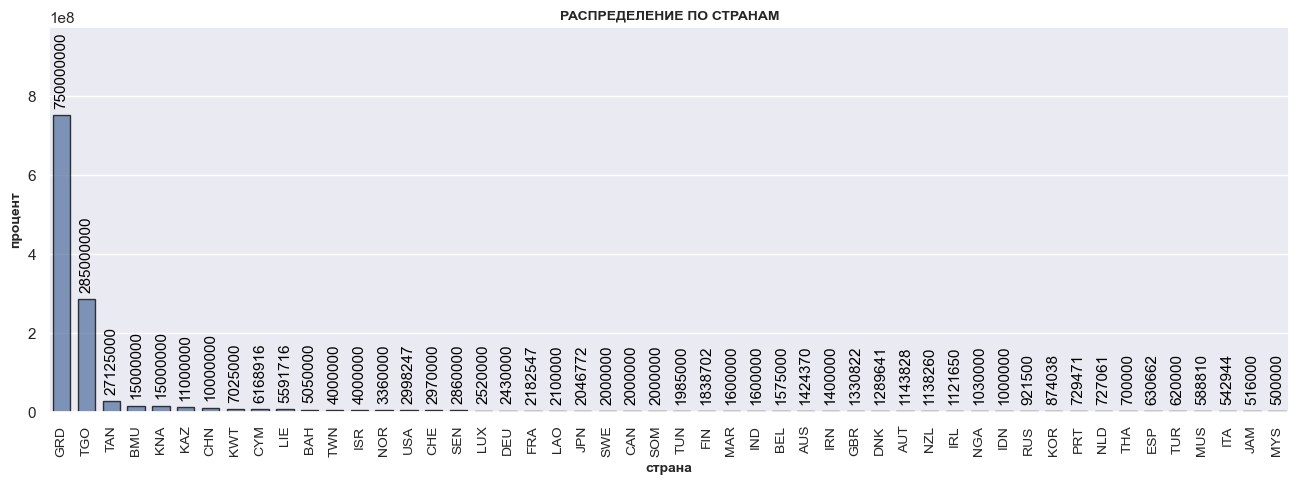

In [631]:
df_ = df[['country_code', 'funding_total_usd']].groupby('country_code').agg(['median'])['funding_total_usd'].squeeze()
df_ = df_.sort_values(ascending=False)
bar_plor_func(df_, x_name = 'страна', y_name = 'процент', title_name='Распределение по странам', num_col=50)

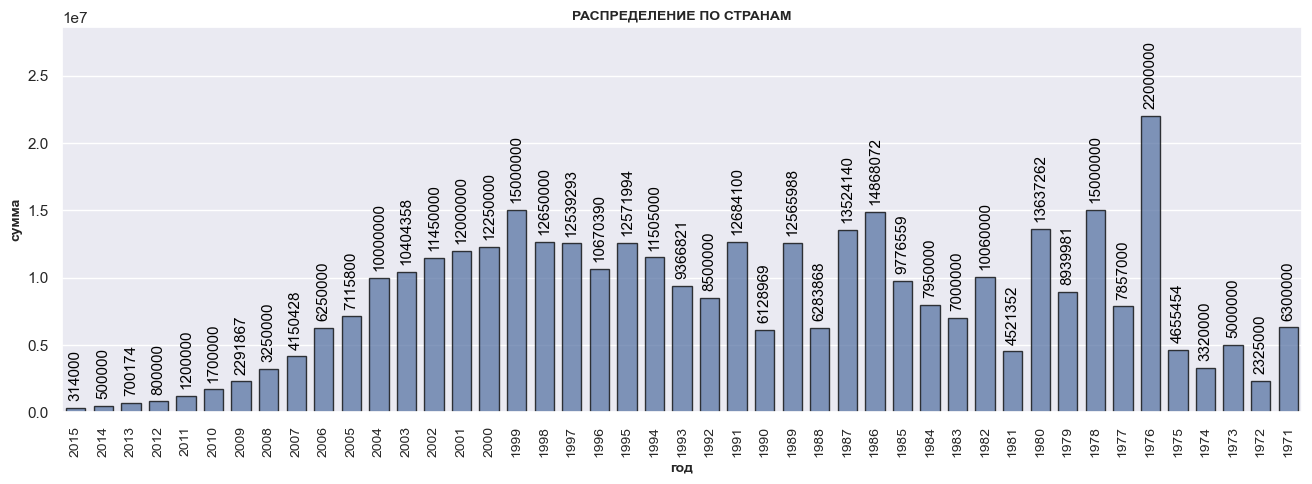

In [619]:
df_ = df[['founded_at', 'funding_total_usd']].groupby('founded_at').agg(['median'])['funding_total_usd'].squeeze()
df_ = df_.sort_index(ascending=False)
bar_plor_func(df_, x_name = 'год', y_name = 'сумма', title_name='Распределение по годам', num_col=50)

Количество вложение было болье всего в 2007, далее сумма начинает падать.

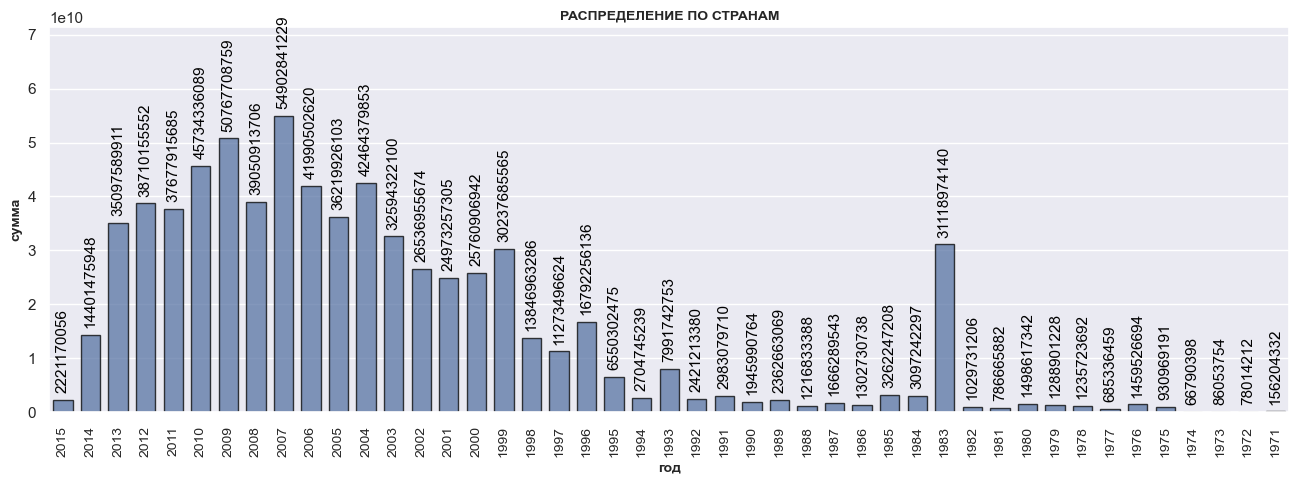

In [621]:
df_ = df[['founded_at', 'funding_total_usd']].groupby('founded_at').agg(['sum'])['funding_total_usd'].squeeze()
df_ = df_.sort_index(ascending=False)
bar_plor_func(df_, x_name = 'год', y_name = 'сумма', title_name='Распределение по годам', num_col=50)

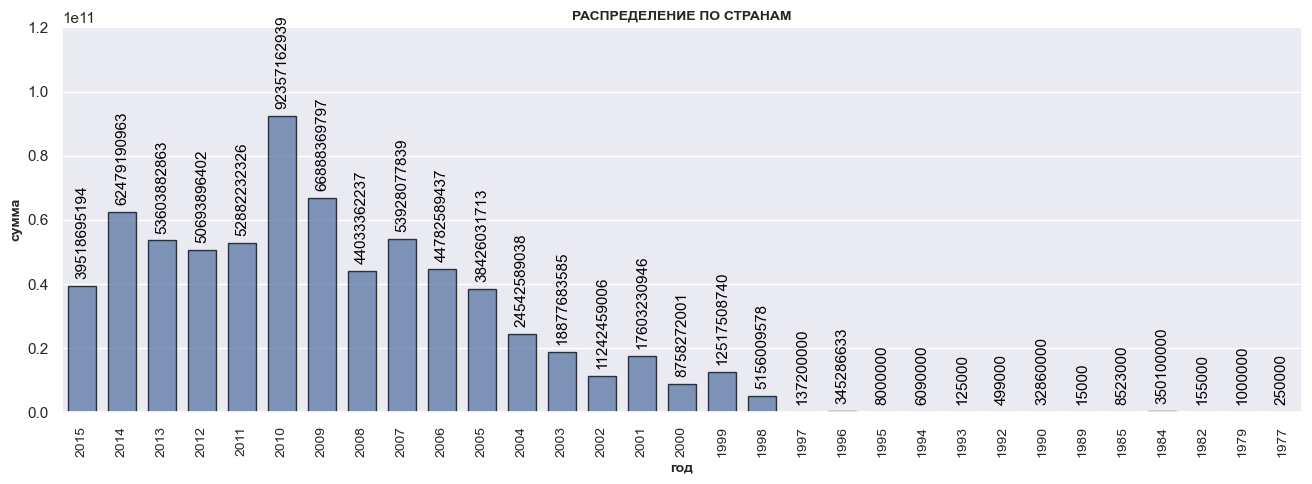

In [627]:
df_ = df[['first_funding_at', 'funding_total_usd']].groupby('first_funding_at').agg(['sum'])['funding_total_usd'].squeeze()
df_ = df_.sort_index(ascending=False)
bar_plor_func(df_, x_name = 'год', y_name = 'сумма', title_name='Распределение по годам', num_col=50)

Посмотрим на еще один столбец, количество зарытых стартапов по годам. Видно, что количество закрытий стартапов увеличивается с увеличением года.

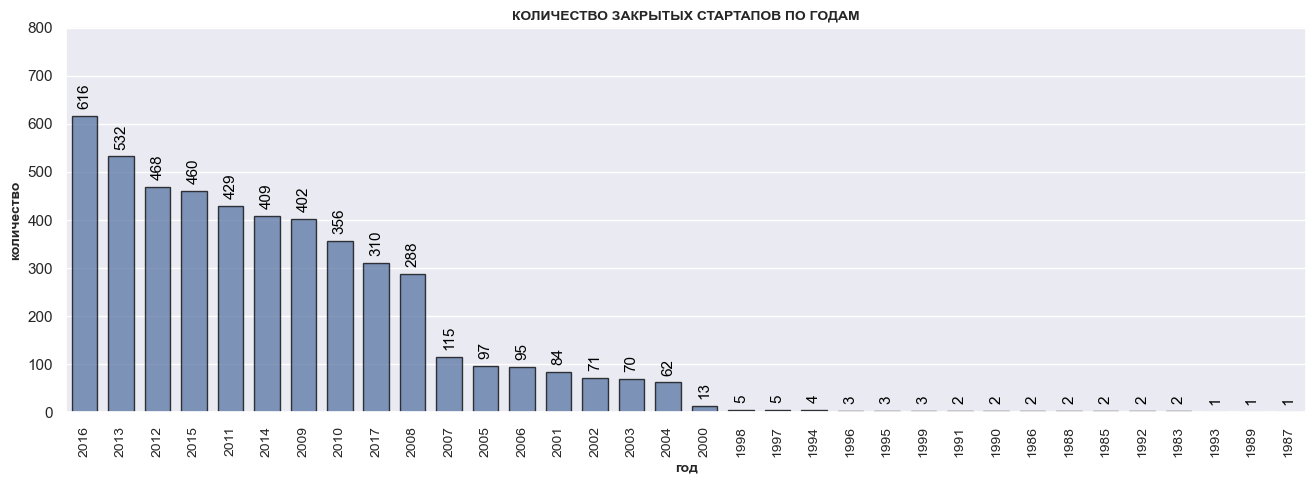

In [637]:
df_closed = train[['closed_at']].dropna()
df_closed['closed_at'] = df_closed['closed_at'].dt.year
df_closed = df_closed['closed_at'].value_counts()
bar_plor_func(df_closed, x_name = 'год', y_name = 'количество', title_name='количество закрытых стартапов по годам', num_col=50)

Посмотрим на значения числового признака <b>funding_total_usd</b>

In [460]:
styles = [dict(selector="caption", props=[("text-align", "center"),
                                          ("font-size", "110%"),
                                          ("font-weight", "bold"), 
                                          ("color","gray")])]
float_format = '{:_.2f}'.format
display(pd.DataFrame({'Описательние признака funding_total_usd': (df['funding_total_usd'].describe().apply(lambda x: "{:,.0f}".format(x)))}).style.\
        set_table_attributes("style='border:1px solid;font-size:14px;margin:14px;margin-left:12px'").\
        set_caption(f'Описательная статистика').\
        set_table_styles(styles))

,Описательние признака funding_total_usd
count,"37,223"
mean,"18,783,584"
std,"187,248,001"
min,1
25%,"400,483"
50%,"2,175,000"
75%,"10,673,084"
max,"30,079,503,000"


Среднее и медиана отличаются почти на порядок, значит есть отдельные выбросы которые портят нам статистику, это видно по значению max которое намного больше среднего и медианы. Посмотрим на распределение и диаграмму размаха.

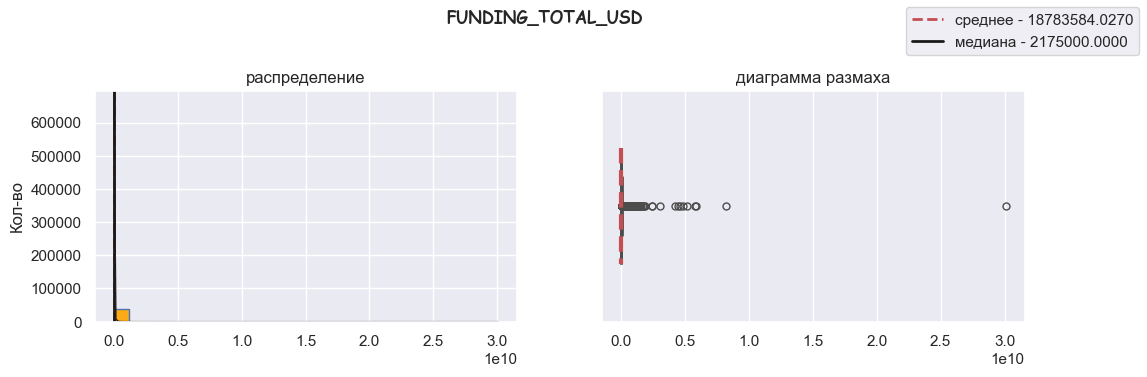

In [463]:
graph_num_plot(df, 'funding_total_usd')

Попробуем отсеить часть данных выше пороша 0.95. Среднее уменьшиловь почти в 3 раза, но различия с медианой остаются и сохраняется большой размах (std). По графику видно, что много значений не попадают в доверительный интервал.

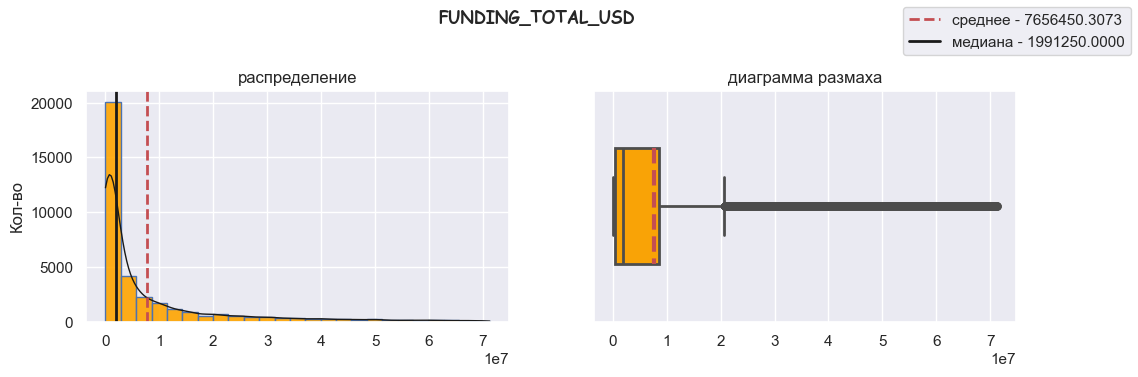

count       35_361.00
mean     7_656_450.31
std     12_902_337.67
min              1.00
25%        360_000.00
50%      1_991_250.00
75%      8_500_000.00
max     71_259_078.00
Name: funding_total_usd, dtype: float64

Количество отброшнных данных: 1862


In [467]:
df_ = df[df['funding_total_usd']< df['funding_total_usd'].quantile(0.95)]
graph_num_plot(df_, 'funding_total_usd')
display(df_['funding_total_usd'].describe())
print(f'Количество отброшнных данных: {df.shape[0] - df_.shape[0]}')

Уменьшение порога до 0.75. Позволяет выровнять статистику, но за счет этого отброшено ворядка 10 т. данных

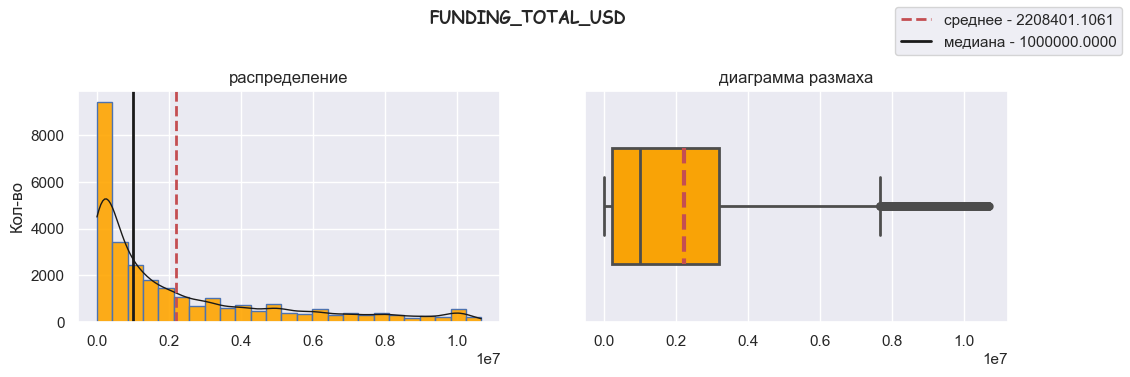

count       27_917.00
mean     2_208_401.11
std      2_695_389.57
min              1.00
25%        225_790.00
50%      1_000_000.00
75%      3_200_000.00
max     10_671_168.00
Name: funding_total_usd, dtype: float64

Количество отброшнных данных: 9306


In [470]:
df_ = df[df['funding_total_usd']< df['funding_total_usd'].quantile(0.75)]
graph_num_plot(df_, 'funding_total_usd')
display(df_['funding_total_usd'].describe())
print(f'Количество отброшнных данных: {df.shape[0] - df_.shape[0]}')

Слишком много маленьких стартапов, но при этом есть и большие, финансирование которых в разы больше.

<a id='section2'></a>

### 2. Предобработка данных

Проверим данные на наличие пропусков и дубликатов. Посмотрим, корректны ли типы данных у каждого признака. При необходимости устраним все проблемы с данными.

Заполним пропуски <b>category_list</b> константой 'NaN'.
Потом можно попрововать восстановить через наиболее часто встречающуюся категорию. 
Так же можно попробовать составить словарь категория - медианная сумма инвестирования для данной категории и сопоставить уже с пропущенными.
train[['category_list', 'funding_total_usd']].groupby('category_list').median().sort_values('funding_total_usd', ascending=False).to_dict(), но это после выделения основных категорий. Пожно еще попробовать привязать к году появления, какой-то бум определенной технологии мог привести к появению большого количества стартапов в определенной области. 

In [476]:
train['category_list'] = train['category_list'].fillna('NaN')

Приведем столбец <b>status</b> к бинарному

In [479]:
mask = {'operating':0, 'closed': 1}
train['status'] = train['status'].map(mask)
train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828_626.00,0,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22_250_000.00,0,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,0,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


In [481]:
df_train = train.copy()

Как было показано в первой части больше всего стартапов в USA, причем отличие достаточно сущещаственное. Заполним пропущенные значения в данном столбце константой "USA"

In [484]:
df_train['country_code'].value_counts().head()

country_code
USA    29702
GBR     2925
CAN     1540
IND     1276
CHN     1240
Name: count, dtype: int64

In [486]:
df_train['country_code'] = df_train['country_code'].fillna('USA')

Посмотрим на количество стартапов по штатам.

In [489]:
df_train['state_code'].value_counts().head()

state_code
CA    10219
NY     3112
MA     2020
TX     1562
H9     1510
Name: count, dtype: int64

Больше всего стартапов в CA. Заполним пропущенные значения в данном столбце константой "CA"

In [492]:
df_train['state_code'] = df_train['state_code'].fillna('CA')

Попробуем синтезировать новые признаки

Создадим признак частоты встречаемости страны. Для этого составим словарь и и потом применим к нашему датасету

In [496]:
diction = df_train[['country_code', 'status']].groupby('country_code').describe()['status']['mean'].round(2).to_dict()
df_train['persent_open'] = df_train['country_code'].map(diction)
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,persent_open
0,Lunchgate,Online Reservations|Restaurants,828_626.00,0,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.09
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.10
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.10
3,Sancilio and Company,Health Care,22_250_000.00,0,USA,CA,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.10
4,WireTough Cylinders,Manufacturing,NaN,0,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.10


Создадим похожий признак для штата

In [498]:
diction = df_train[['state_code', 'status']].groupby('state_code').describe()['status']['mean'].round(2).to_dict()
df_train['code_persent_open'] = df_train['state_code'].map(diction)
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,persent_open,code_persent_open
0,Lunchgate,Online Reservations|Restaurants,828_626.00,0,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.09,0.06
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.10,0.14
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.10,0.14
3,Sancilio and Company,Health Care,22_250_000.00,0,USA,CA,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.10,0.14
4,WireTough Cylinders,Manufacturing,NaN,0,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.10,0.07


Добавим новый признак - интервал между датой последнего и первого финансирования. Можно было бы добавить признак 
разницы между основанием и первым финансирванием (train['delta_1'] = (train['first_funding_at'] - train['founded_at']).dt.days), но для тренировочного датасета его не почтитать

In [500]:
df_train['delta_2'] = (df_train['last_funding_at'] - df_train['first_funding_at']).dt.days
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,persent_open,code_persent_open,delta_2
0,Lunchgate,Online Reservations|Restaurants,828_626.00,0,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.09,0.06,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.10,0.14,1393
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.10,0.14,681
3,Sancilio and Company,Health Care,22_250_000.00,0,USA,CA,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.10,0.14,1051
4,WireTough Cylinders,Manufacturing,NaN,0,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.10,0.07,0


Добавим признак финаннсирование на один раунд <b>fund_one_round</b> и дельта на один раунд <b>delta_one_round</b>

In [505]:
df_train['delta_one_round'] = df_train['delta_2'] // df_train['funding_rounds']
df_train['fund_one_round'] = df_train['funding_total_usd'] / df_train['funding_rounds']
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,persent_open,code_persent_open,delta_2,delta_one_round,fund_one_round
0,Lunchgate,Online Reservations|Restaurants,828_626.00,0,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT,0.09,0.06,1310,655,414_313.00
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT,0.10,0.14,1393,348,10_733_754.75
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT,0.10,0.14,681,227,11_818_793.67
3,Sancilio and Company,Health Care,22_250_000.00,0,USA,CA,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT,0.10,0.14,1051,350,7_416_666.67
4,WireTough Cylinders,Manufacturing,NaN,0,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT,0.10,0.07,0,0,NaN


Восстановим пропущенные значения в столбце финансирования. Для этого составим словарь с медианнными занчениями финансирования для каждой страны.

In [508]:
dict_fund_country = df_train.dropna(subset=['fund_one_round'])
dict_fund_country = dict_fund_country[['country_code', 'fund_one_round']].groupby('country_code').median().to_dict()['fund_one_round']

Получим уникальные значения названия стран

In [510]:
country_names = df_train[df_train['funding_total_usd'].isna()]['country_code'].unique()

Заполним пропущенные значения признака ффинансирование на один раунд <b>fund_one_round</b>. Если значение отсутствует какой-то страны (country_code) заполним медианой, вычесленой по всем.

In [514]:
mediana = df_train.dropna(subset=['fund_one_round'])['fund_one_round'].median()

for i in country_names:
    try:
        df_train.loc[(df_train['fund_one_round'].isna()) & (df_train['country_code'] == i), ['fund_one_round']] = dict_fund_country[i]
    except:
        df_train.loc[(df_train['fund_one_round'].isna()) & (df_train['country_code'] == i), ['fund_one_round']] = mediana

Так же заполним значения для столбца <b>funding_total_usd</b>

In [517]:
df_train['funding_total_usd'] = df_train['fund_one_round'] * df_train['funding_rounds']

Добавим еще один признак продолжительность жизни стартапа <b>lifetime</b>, так как он есть в тестовом датасете, то он может сработать.
Для создания признака воспользуемся ф-ей <b>calculus_lifetime</b>. Функция расчитывает срок жизни стартапа относительно точки выгрузки данных 2018 г. При расчете учитывается самая ранняя дата появления стартапа.

In [520]:
df_train['lifetime'] = df_train.apply(calculus_lifetime, axis=1).dt.days

Поработаем со столбцом <b>сategory_list</b>. Добавим новый признак длины описания категорий. Если много перечислений в данном признаке, то это может указывать на то, что у стартапа много разных направлений. Бюджет будет делится на данное количество и может нехватить средств, что бы сделать прорыв в определенном направлении.

In [522]:
num_description = df_train['category_list'].str.lower().str.split('|', expand=True).applymap(lambda x: 1 if x != None else 0)
df_train['categ_long_pers'] = 1 - num_description.sum(axis=1)/num_description.shape[1]

Было бы неплохим создать признак буджет на одно направление, но тут необходимо хорошо разграничить категории описания, так как они могут дублироваться.

Как отдельнные признаки зададим года финансирования. Хотя практика показала, что можно отсавить как есть и Catboost хорошо справиться.

In [525]:
# df_train['first_funding_at'] = df_train['first_funding_at'].dt.year
# df_train['last_funding_at'] = df_train['last_funding_at'].dt.year

Поработаем со столбцом <b>сategory_list</b> попробуем максимизировать категории. Для этого создадим список всех категорий. 

In [527]:
all_category_list = []
for i in df_train['category_list'].str.lower().str.split(r'|', expand=False).values:
    if type(i) != float:
        all_category_list.extend(i)

Создадим словарь в часотой встречаемости категой. Из него потом сделает дополнительный признак. Зададим 100 основых категорий (параметр "num"). Количество категорий выбиралось эмпирически, так что бы потом не было большого количества пропущенных категорий.

In [529]:
num = 100
data = pd.DataFrame(all_category_list, columns=['name'])
data = data.value_counts().head(num).reset_index().drop('count', axis=1)
data['rang'] = np.round(np.arange(num, 0, -1)/num, 2)
all_category_dic = data.set_index('name').to_dict()['rang']

Выделим названия основных категорий

In [531]:
name_main_category = data['name'].value_counts().index

Пробежимся по всем строкам и создадим новый столбец с одной категорией

In [533]:
name_main_category_frame = []
for i in df_train['category_list']:
    done = True
    if type(i) is not float:
        i = i.lower().split('|')
        for name in name_main_category:
            if name in i:
                name_main_category_frame.append(name)
                done = False
                break
        if done:
            name_main_category_frame.append('other')
            done = True
            
    else:
        name_main_category_frame.append('other')
df_train['category_list_one'] = name_main_category_frame
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,last_funding_at,closed_at,persent_open,code_persent_open,delta_2,delta_one_round,fund_one_round,lifetime,categ_long_pers,category_list_one
0,Lunchgate,Online Reservations|Restaurants,828_626.00,0,CHE,25,Zurich,Zürich,2,2009-10-17,...,2014-12-01,NaT,0.09,0.06,1310,655,414_313.00,2998,0.95,restaurants
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,2014-02-25,NaT,0.10,0.14,1393,348,10_733_754.75,4748,0.93,medical devices
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,2014-07-02,NaT,0.10,0.14,681,227,11_818_793.67,4383,0.97,biotechnology
3,Sancilio and Company,Health Care,22_250_000.00,0,USA,CA,NaN,NaN,3,2004-01-01,...,2014-07-18,NaT,0.10,0.14,1051,350,7_416_666.67,5114,0.97,health care
4,WireTough Cylinders,Manufacturing,1_500_000.00,0,USA,VA,VA - Other,Bristol,1,2010-05-12,...,2012-02-01,NaT,0.10,0.07,0,0,1_500_000.00,2791,0.97,manufacturing


Посмотрим на первые 50 категорий. Остались очень похожие названия. Например software, enterprise software и 
hardware + softwar. Их можно уже объединить вручную

In [535]:
df_train['category_list_one'].value_counts().head(30)

category_list_one
software               7017
mobile                 3401
biotechnology          3078
other                  2889
nan                    2465
e-commerce             1728
curated web            1302
games                  1194
health care            1112
clean technology       1076
enterprise software     998
finance                 975
health and wellness     941
hardware + software     913
advertising             900
manufacturing           871
social media            773
education               765
analytics               723
technology              644
services                620
internet                571
semiconductors          514
security                482
marketplaces            480
web hosting             452
real estate             432
apps                    398
consulting              387
hospitality             382
Name: count, dtype: int64

In [536]:
df_train.loc[(df_train['category_list_one'] == 'enterprise software') | (df_train['category_list_one'] == 'hardware + software'), 'category_list_one'] = 'software'
df_train.loc[(df_train['category_list_one'] == 'health and wellness') | (df_train['category_list_one'] == 'health diagnostics'), 'category_list_one'] = 'health care'
df_train.loc[(df_train['category_list_one'] == 'digital media') | (df_train['category_list_one'] == 'social media'), 'category_list_one'] = 'media'
df_train.loc[(df_train['category_list_one'] == 'curated web') | (df_train['category_list_one'] == 'web hosting'), 'category_list_one'] = 'web'
df_train.loc[(df_train['category_list_one'] == 'big data analytics') | (df_train['category_list_one'] == 'big data'), 'category_list_one'] = 'big data'
df_train.loc[(df_train['category_list_one'] == 'apps')| (df_train['category_list_one'] == 'mobile commerce')| 
                                            (df_train['category_list_one'] == 'iphone')
                                            | (df_train['category_list_one'] == 'android')
                                            | (df_train['category_list_one'] == 'ios'), 'category_list_one'] = 'mobile'

Посмотрим на результат. При этом пропушенные значения, ранее замененные на "NaN" отнесем к самой большой категории software

In [538]:
df_train.loc[(df_train['category_list_one'] == 'nan'), 'category_list_one'] = 'software'

In [539]:
df_train['category_list_one'].value_counts().head(30)

category_list_one
software            11393
mobile               4084
biotechnology        3078
other                2889
health care          2393
web                  1754
e-commerce           1728
games                1194
media                1132
clean technology     1076
finance               975
advertising           900
manufacturing         871
education             765
analytics             723
technology            644
services              620
internet              571
semiconductors        514
security              482
marketplaces          480
real estate           432
consulting            387
hospitality           382
medical devices       380
pharmaceuticals       358
saas                  340
big data              339
transportation        337
payments              336
Name: count, dtype: int64

Создадим столбец частоты встречающейся категории.

In [542]:
mask = df_train[['category_list_one', 'status']].groupby('category_list_one').describe().round(4)['status']['mean'].to_dict()
df_train['category_list_pers'] = df_train['category_list_one'].map(mask)

Посмотрим на итоговый датасет и убедимся в отсутствии пропусков.

In [548]:
df_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,...,closed_at,persent_open,code_persent_open,delta_2,delta_one_round,fund_one_round,lifetime,categ_long_pers,category_list_one,category_list_pers
0,Lunchgate,Online Reservations|Restaurants,828_626.00,0,CHE,25,Zurich,Zürich,2,2009-10-17,...,NaT,0.09,0.06,1310,655,414_313.00,2998,0.95,restaurants,0.08
1,EarLens,Manufacturing|Medical|Medical Devices,42_935_019.00,0,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,...,NaT,0.10,0.14,1393,348,10_733_754.75,4748,0.93,medical devices,0.06
2,Reviva Pharmaceuticals,Biotechnology,35_456_381.00,0,USA,CA,SF Bay Area,San Jose,3,2006-01-01,...,NaT,0.10,0.14,681,227,11_818_793.67,4383,0.97,biotechnology,0.06
3,Sancilio and Company,Health Care,22_250_000.00,0,USA,CA,NaN,NaN,3,2004-01-01,...,NaT,0.10,0.14,1051,350,7_416_666.67,5114,0.97,health care,0.05
4,WireTough Cylinders,Manufacturing,1_500_000.00,0,USA,VA,VA - Other,Bristol,1,2010-05-12,...,NaT,0.10,0.07,0,0,1_500_000.00,2791,0.97,manufacturing,0.06


In [549]:
df_train.isna().sum()

name                      1
category_list             0
funding_total_usd         0
status                    0
country_code              0
state_code                0
region                 6359
city                   6359
funding_rounds            0
founded_at                0
first_funding_at          0
last_funding_at           0
closed_at             47599
persent_open              0
code_persent_open         0
delta_2                   0
delta_one_round           0
fund_one_round            0
lifetime                  0
categ_long_pers           0
category_list_one         0
category_list_pers        0
dtype: int64

В интересующих столбцах пропущенных значений нет.<br>
Cтолбцы: 
name (индивидульный признак, будет неинформативен), 
region (дублирует country_code, state_code, 
cit (дублирует country_code, state_code), 
closed_at (дублирует status) нас не интеерсуют. 

In [552]:
df_train = df_train.drop(['region', 'city', 'closed_at', 'name'], axis=1)

<a id='section3'></a>

### 3. Проверка на мультиколлинеарность.

Изучим взаимосвязь между признаками. Рассчитаем коэффициенты корреляции между всеми признаками.
Построим диаграммы рассеяния scatterplot для целевого признака и всех количественных признаков с учётом значения категориальных признаков.

Рассчитаем коэффициент связи между признаками и построим тепловую карту. Для этого воспользуемся библиотекой phik. При расчете выберем небольшое количество, что бы быстрее посчиталось.

interval columns not set, guessing: ['funding_total_usd', 'status', 'funding_rounds', 'persent_open', 'code_persent_open', 'delta_2', 'delta_one_round', 'fund_one_round', 'lifetime', 'categ_long_pers', 'category_list_pers']


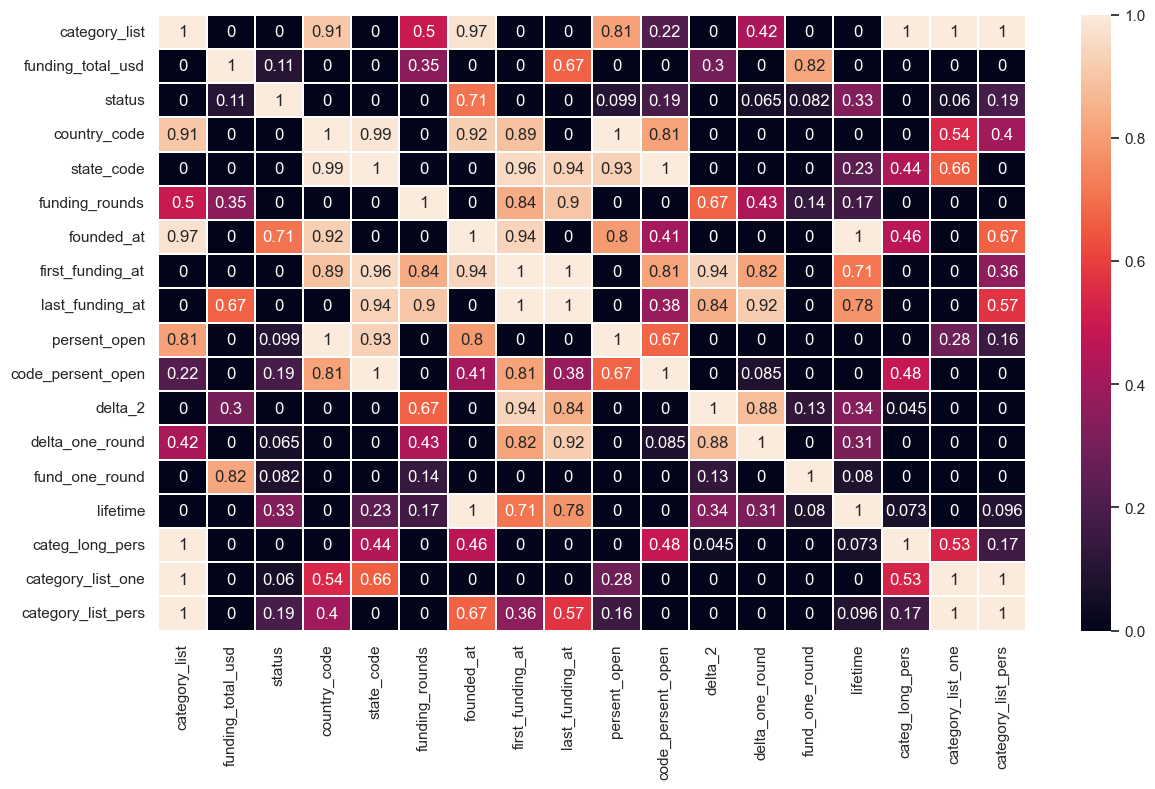

In [564]:
plt.figure(figsize=(14, 8))
ax=sns.heatmap(df_train.sample(1000).phik_matrix(), 
            annot = True, 
            vmin=0, 
            vmax=1, 
            cmap= 'rocket', 
            linewidths=0.1, 
            linecolor='white', 
            cbar_kws= {'orientation': 'vertical'});

Видны следующие закономерности:
Между некоторыми признаками наблюдается высокая связь. Например founded_at сильно связан с признаками <b>funding_total_usd, country_code, state_code, first_funding_at, last_funding_at, code_persent_open, fund_one_round, category_long_pers, category_list_one, category_list_pers</b>. В качестве второго примера можно отнести category_list у которой сильная взаимосвязь с <b>category_long_pers, category_list_one, category_list_pers</b>

Отдельно выведем столбец только для целевого признака и посмотрим с кем у нее сильная связь.

interval columns not set, guessing: ['funding_total_usd', 'status', 'funding_rounds', 'persent_open', 'code_persent_open', 'delta_2', 'delta_one_round', 'fund_one_round', 'lifetime', 'categ_long_pers', 'category_list_pers']


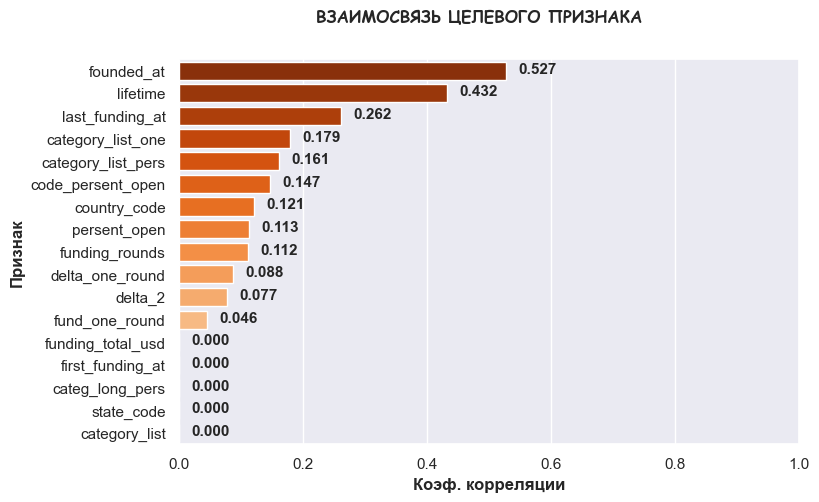

In [569]:
df_train_phik = df_train.sample(2000).phik_matrix()['status'].sort_values(ascending=False)[1:]
corr_plor_func(df_train_phik, (0,1), 'Взаимосвязь целевого признака')

По полученной таблице видна зависимость целевого признак c признаками:

- высокая связь с признаком <b>last_funding_at</b>, 0.64
- высокая связь с признаком <b>founded_at</b>, 0.614
- средняя связь с признаком <b>first_founding_at</b>, 0.474
- средняя связь с признаком <b>lifetime</b>, 0.439
- слабая связь с признаком <b>code_persent_open</b>, 0.189
- слабая связь с признаком <b>category_list_pers</b>, 0.140
- слабая связь с признаком <b>funding_rounds</b>, 0.109

Для остальных признаков наблюдается очень слабая теснота связи. 
Надо будет посмотреть какие признаки выведет сама модель.

При обучении модели избавимся от некоторых признаков, которые сильно взаимосвязаны или для которых взаимосвязь с целевым признаком оказалась миниальной.
К таким призначам относятся 'name','state_code', 'country_code', 'region', 'city', 'category_list', 'founded_at', 'closed_at'

<a id='section4'></a>

### 4. Выбор и обучение модели

Приступим к обучению.
Создадим тренировочные и тестовые выборки. После этого применим отдельно преобразования, чтобы небыло утечки данных в тестовую выборку.

In [578]:
X = train.drop(['status'], axis=1)
y = train['status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= TEST_SIZE, random_state=RANDOM_STATE, stratify = train['status'])

In [580]:
df_train = X_train.join(y_train).reset_index(drop=True)
df_test = X_test.join(y_test).reset_index(drop=True)
df_train.shape, df_test.shape

((44638, 13), (7878, 13))

Воспользуеся готовой функцией и применим к нашем двум датасетам

In [583]:
df_train_prep, diction_country_code, diction_state_code, diction_category_list_one = preproces(df_train, train_flag=True)
df_test_prep, _, _, _ = preproces(df_test, diction_country_code, diction_state_code, diction_category_list_one, train_flag=True)

In [584]:
df_test_prep.head()

,categ_long_pers,category_list,category_list_one,category_list_pers,city,closed_at,code_persent_open,country_code,delta_2,delta_one_round,...,fund_one_round,funding_rounds,funding_total_usd,last_funding_at,lifetime,name,persent_open,region,state_code,status
0,0.96,NaN,software,0.12,NaN,NaT,0.14,USA,0,0,...,49_488.00,1,49_488.00,2014-01-31,2022,Bondoo Baby,0.10,NaN,CA,0
1,0.83,Ad Targeting|Advertising Platforms|Mobile Adve...,other,0.07,Santiago,NaT,0.05,CHL,0,0,...,500_000.00,1,500_000.00,2013-04-01,1842,Arara,0.04,Santiago,12,0
2,0.91,EdTech|Education,edtech,0.03,New York,NaT,0.08,USA,1034,258,...,2_687_542.00,4,10_750_168.00,2014-02-28,2618,Skillshare,0.10,New York City,NY,0
3,0.91,Advertising|Internet Marketing,internet marketing,0.11,San Francisco,NaT,0.14,USA,0,0,...,1_500_000.00,1,1_500_000.00,2012-01-01,2832,"Adaptive Advertising, Inc.",0.10,SF Bay Area,CA,0
4,0.96,Hardware + Software,software,0.12,NaN,NaT,0.14,USA,0,0,...,1_500_000.00,1,1_500_000.00,2013-12-02,5114,WALTOP,0.10,NaN,CA,0


Избавимся от некоторых признаков, которые сильно взаимосвязаны или для которых взаимосвязь с целевым признаком оказалась миниальной.

In [586]:
df_train_prep_ = df_train_prep.drop(['state_code', 'country_code', 'region', 'city', 'category_list', 'name', 'founded_at', 'closed_at'], axis=1)
df_test_prep_ = df_test_prep.drop(['state_code', 'country_code', 'region', 'city', 'category_list', 'name','founded_at', 'closed_at'], axis=1)

In [587]:
df_train_prep_.head()

,categ_long_pers,category_list_one,category_list_pers,code_persent_open,delta_2,delta_one_round,first_funding_at,fund_one_round,funding_rounds,funding_total_usd,last_funding_at,lifetime,persent_open,status
0,0.97,health care,0.05,0.14,410,205,2014-02-06,462_500.00,2,925_000.00,2015-03-23,1826,0.10,0
1,0.97,technology,0.07,0.09,0,0,2015-08-13,70_000.00,1,70_000.00,2015-08-13,1767,0.10,0
2,0.97,biotechnology,0.06,0.08,0,0,2008-11-26,2_700_000.00,1,2_700_000.00,2008-11-26,3503,0.10,0
3,0.97,software,0.12,0.07,0,0,2015-11-24,3_792_418.20,1,3_792_418.20,2015-11-24,857,0.08,1
4,0.80,software,0.12,0.14,488,162,2013-05-01,91_666.67,3,275_000.00,2014-09-01,1767,0.10,0


Проверим, что не осталось нулевых признаков

In [593]:
df_train_prep_.isna().sum().sum(), df_test_prep_.isna().sum().sum()

(0, 0)

In [595]:
df_train_prep_X = df_train_prep_.drop(['status'], axis=1)
df_test_prep_X = df_test_prep_.drop(['status'], axis=1)

df_train_prep_y = df_train_prep_['status']
df_test_prep_y = df_test_prep_['status']

cat_col = ['category_list_one']

encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

df_train_prep_X_ohe = encoder.fit_transform(df_train_prep_X[cat_col])
df_test_prep_X_ohe = encoder.transform(df_test_prep_X[cat_col])

encoder_col = encoder.get_feature_names_out() #get_feature_names()

df_train_prep_X_ohe = pd.DataFrame(df_train_prep_X_ohe, columns=encoder_col)
df_test_prep_X_ohe = pd.DataFrame(df_test_prep_X_ohe, columns=encoder_col)


df_train_prep_X = pd.concat([df_train_prep_X_ohe, df_train_prep_X.reset_index(drop=True).drop('category_list_one', axis=1)], axis=1)
df_test_prep_X = pd.concat([df_test_prep_X_ohe, df_test_prep_X.reset_index(drop=True).drop('category_list_one', axis=1)], axis=1)


In [597]:
df_train_prep_X.shape, df_train_prep_y.shape

((44638, 98), (44638,))

Учитываю отсутствие линейной зависимости воспользуется моделью градинтного бустинга. В качестве такой модели выберем CatBoost. Как показали эксперименты (пробегался по парметрам GridSearchCV) хорошие значения дает так же модель с базовыми параметрами. 

In [600]:
clf_2 = cb.CatBoostClassifier()

params = {'nan_mode': ['Min'],
 'eval_metric': ['F1'],
 'iterations': [30],
 'sampling_frequency': ['PerTree'],
 'leaf_estimation_method': ['Newton'],
 'random_score_type': ['NormalWithModelSizeDecrease'],
 'grow_policy': ['SymmetricTree'],
 'penalties_coefficient': [1],
 'boosting_type': ['Plain'],
 'model_shrink_mode': ['Constant'],
 'feature_border_type': ['GreedyLogSum'],
 'bayesian_matrix_reg': [0.1, 0.15],
 'eval_fraction': [0],
 'force_unit_auto_pair_weights': [False],
 'l2_leaf_reg': [2, 3, 4],
 'random_strength': [1, 2],
 'rsm': [0.9, 1],
 'boost_from_average': [False],
 'model_size_reg': [0.4, 0.5, 0.6],
 'subsample': [0.8],
 'use_best_model': [False],
 'random_seed': [0],
 'depth': [10, 13],
 'posterior_sampling': [False],
 'border_count': [254],
 'classes_count': [0],
 'auto_class_weights': ['None'],
 'sparse_features_conflict_fraction': [0],
 'leaf_estimation_backtracking': ['AnyImprovement'],
 'best_model_min_trees': [1, 2],
 'model_shrink_rate': [0],
 'min_data_in_leaf': [1, 2],
 'loss_function': ['Logloss'],
 'learning_rate': [0.3],
 'score_function': ['Cosine'],
 'leaf_estimation_iterations': [10],
 'bootstrap_type': ['MVS'],
 'max_leaves': [8192],
 'task_type': ['GPU']
         }

scorer = make_scorer(f1_score)
clf_grid = GridSearchCV(estimator=clf_2, param_grid=params, scoring=scorer, cv=5)

In [602]:
clf_grid.fit(df_train_prep_X, df_train_prep_y)

0:	learn: 0.7712615	total: 4.26ms	remaining: 123ms
1:	learn: 0.8051810	total: 70.5ms	remaining: 987ms
2:	learn: 0.8681575	total: 137ms	remaining: 1.23s
3:	learn: 0.8691012	total: 203ms	remaining: 1.32s
4:	learn: 0.8870941	total: 271ms	remaining: 1.35s
5:	learn: 0.8943249	total: 338ms	remaining: 1.35s
6:	learn: 0.8991817	total: 406ms	remaining: 1.33s
7:	learn: 0.8999836	total: 473ms	remaining: 1.3s
8:	learn: 0.9010127	total: 540ms	remaining: 1.26s
9:	learn: 0.9008980	total: 606ms	remaining: 1.21s
10:	learn: 0.9010451	total: 674ms	remaining: 1.16s
11:	learn: 0.9055131	total: 740ms	remaining: 1.11s
12:	learn: 0.9058690	total: 807ms	remaining: 1.05s
13:	learn: 0.9066407	total: 875ms	remaining: 1000ms
14:	learn: 0.9077347	total: 943ms	remaining: 943ms
15:	learn: 0.9100324	total: 1.01s	remaining: 884ms
16:	learn: 0.9110320	total: 1.08s	remaining: 824ms
17:	learn: 0.9122637	total: 1.14s	remaining: 763ms
18:	learn: 0.9138710	total: 1.21s	remaining: 702ms
19:	learn: 0.9149210	total: 1.28s	remai

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001FACEBA1370>,
             param_grid={'auto_class_weights': ['None'],
                         'bayesian_matrix_reg': [0.1, 0.15],
                         'best_model_min_trees': [1, 2],
                         'boost_from_average': [False],
                         'boosting_type': ['Plain'], 'bootstrap_type': ['MVS'],
                         'border_count': [254], 'classes_count': [0],
                         'depth': [10, 13], 'eval_fraction': [0],...
                         'learning_rate': [0.3], 'loss_function': ['Logloss'],
                         'max_leaves': [8192], 'min_data_in_leaf': [1, 2],
                         'model_shrink_mode': ['Constant'],
                         'model_shrink_rate': [0],
                         'model_size_reg': [0.4, 0.5, 0.6], 'nan_mode': ['Min'],
                         'penalties_coefficient': [1],
                         'posterior_sampling': [False],
                         'random_score_type': ['NormalWithModelSizeDecrease'], ...},
             scoring=make_scorer(f1_score, response_method='predict'))

Сохраним модель

In [659]:
dump(clf_grid.best_estimator_, "model.joblib")

['model.joblib']

Попробуем немного дообучить лучшую модель, с учетов весов выборкии и увеличения количества итераций

In [667]:
best_param = clf_grid.best_params_.copy()
model = cb.CatBoostClassifier()
best_param['learning_rate'] = 0.3
best_param['class_weights'] = {0: 1, 1: 10}
best_param['iterations'] = 100
model.set_params(**best_param)
model.fit(df_train_prep_X, df_train_prep_y, eval_set=(df_test_prep_X, df_test_prep_y))
y_pred = model.predict(df_test_prep_X)
f1_score(df_test_prep_y, y_pred, average=None)

0:	learn: 0.8999132	test: 0.9776942	best: 0.9776942 (0)	total: 67.3ms	remaining: 6.67s
1:	learn: 0.9153956	test: 0.9733777	best: 0.9776942 (0)	total: 134ms	remaining: 6.59s
2:	learn: 0.9252714	test: 0.9841535	best: 0.9841535 (2)	total: 201ms	remaining: 6.51s
3:	learn: 0.9323177	test: 0.9831975	best: 0.9841535 (2)	total: 269ms	remaining: 6.45s
4:	learn: 0.9357730	test: 0.9825436	best: 0.9841535 (2)	total: 337ms	remaining: 6.4s
5:	learn: 0.9384815	test: 0.9889927	best: 0.9889927 (5)	total: 404ms	remaining: 6.33s
6:	learn: 0.9415196	test: 0.9901486	best: 0.9901486 (6)	total: 471ms	remaining: 6.26s
7:	learn: 0.9419802	test: 0.9904794	best: 0.9904794 (7)	total: 540ms	remaining: 6.21s
8:	learn: 0.9451227	test: 0.9901321	best: 0.9904794 (7)	total: 607ms	remaining: 6.13s
9:	learn: 0.9481882	test: 0.9881092	best: 0.9904794 (7)	total: 674ms	remaining: 6.06s
10:	learn: 0.9503299	test: 0.9889558	best: 0.9904794 (7)	total: 741ms	remaining: 5.99s
11:	learn: 0.9528991	test: 0.9916388	best: 0.9916388 

array([0.99607627, 0.95362083])

Получилось значение [0.99607627, 0.95362083]

Посмотрим важность признаков

In [265]:
data = pd.DataFrame({'feature_importance': model.get_feature_importance(), 
              'feature_names': df_train_prep_X.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

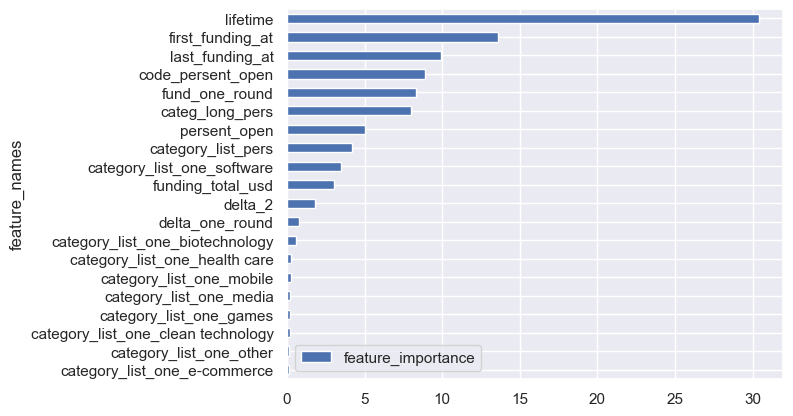

In [267]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

Посмотрим так же модель со стандартными параметрами.

In [273]:
clf_catboost = cb.CatBoostClassifier(n_estimators=100, learning_rate=0.3, max_depth=13, eval_metric="F1", class_weights={0: 1, 1: 10}, task_type="GPU",
                           devices='0')
clf_catboost.fit(df_train_prep_X, df_train_prep_y, eval_set=(df_test_prep_X, df_test_prep_y))
y_pred = clf_catboost.predict(df_test_prep_X)
f1_score(df_test_prep_y, y_pred, average=None)

0:	learn: 0.9156529	test: 0.8892530	best: 0.8892530 (0)	total: 67.9ms	remaining: 6.72s
1:	learn: 0.9335003	test: 0.9036808	best: 0.9036808 (1)	total: 134ms	remaining: 6.58s
2:	learn: 0.9373209	test: 0.9088252	best: 0.9088252 (2)	total: 201ms	remaining: 6.5s
3:	learn: 0.9417168	test: 0.9092896	best: 0.9092896 (3)	total: 269ms	remaining: 6.45s
4:	learn: 0.9457680	test: 0.9079611	best: 0.9092896 (3)	total: 337ms	remaining: 6.4s
5:	learn: 0.9502497	test: 0.9107495	best: 0.9107495 (5)	total: 423ms	remaining: 6.63s
6:	learn: 0.9542140	test: 0.9083584	best: 0.9107495 (5)	total: 499ms	remaining: 6.63s
7:	learn: 0.9595022	test: 0.9072891	best: 0.9107495 (5)	total: 568ms	remaining: 6.53s
8:	learn: 0.9635720	test: 0.9074224	best: 0.9107495 (5)	total: 634ms	remaining: 6.41s
9:	learn: 0.9659945	test: 0.9060156	best: 0.9107495 (5)	total: 701ms	remaining: 6.31s
10:	learn: 0.9679821	test: 0.9068195	best: 0.9107495 (5)	total: 769ms	remaining: 6.22s
11:	learn: 0.9704883	test: 0.9091576	best: 0.9107495 (

array([0.98948248, 0.89206576])

Получилось значение [0.98948248, 0.89206576]

Значение метрики f1 получилось немного хуже. Посмотрим важность признаков для модели.

In [276]:
data = pd.DataFrame({'feature_importance': clf_catboost.get_feature_importance(), 
              'feature_names': df_train_prep_X.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

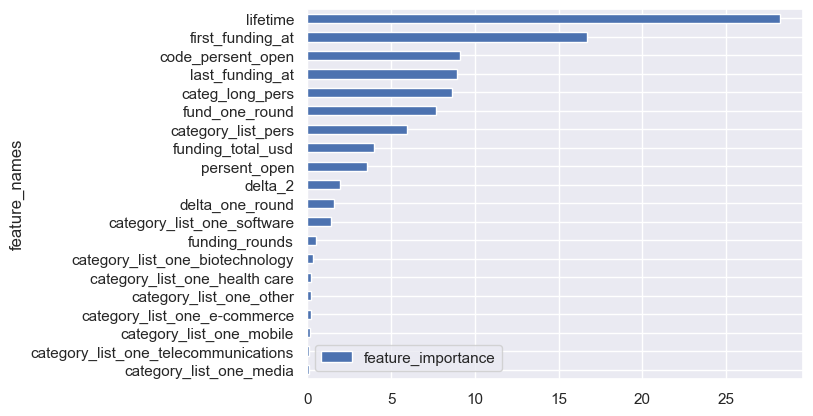

In [277]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

На первое место модель поставила признак <b>lifetime</b>, потом модель придала значение признакам <b>first_funding_at, code_persent_open, last_funding_at</b>. Признак немного сомнительный так как частично всем содержится информация о закрытии стартапа. Останавивает только то, что он последней датой могла считаться дата выгрузки. Признаки <b>first_funding_at</b> и <b>last_funding_at</b> тоже можно поставить под вопрос, так как они содержут значения даты ограниченные датой выгрузки, и появление новых данных на которых модель не обучалась приведет к худшему результату. По хорошему ее бы привязать к какомотк показателю, например инфляции в стране. Можно еще попробовать построить признак на основе вредыдущих данных, например связать с количество финансирования за прошлые года. 

<a id='section5'></a>

### 5. Оценка качества предсказания лучшей модели.

Оценим качество модели на тестовом датасете.

In [328]:
df_test = test.copy()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


Переведем данные в правильный формат.

In [331]:
df_test['first_funding_at'] = pd.to_datetime(df_test['first_funding_at'])
df_test['last_funding_at'] = pd.to_datetime(df_test['last_funding_at'])

Применим функцию преобразования

In [334]:
df_test, _, _, _ = preproces(df_test, diction_country_code, diction_state_code, diction_category_list_one)

Удалим лишние столбцы

In [344]:
df_test = df_test.drop(['country_code', 'state_code', 'region', 'city', 'category_list', 'name'], axis=1)

Проверим на нулевые значения в интересующих нас признаках

In [347]:
df_test.isna().sum()

categ_long_pers       0
category_list_one     0
category_list_pers    0
code_persent_open     0
delta_2               0
delta_one_round       0
first_funding_at      0
fund_one_round        0
funding_rounds        0
funding_total_usd     0
last_funding_at       0
lifetime              0
persent_open          0
dtype: int64

Посмотрим информацию по всему датасету

In [350]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   categ_long_pers     13125 non-null  float64       
 1   category_list_one   13125 non-null  object        
 2   category_list_pers  13125 non-null  float64       
 3   code_persent_open   13125 non-null  float64       
 4   delta_2             13125 non-null  int64         
 5   delta_one_round     13125 non-null  int64         
 6   first_funding_at    13125 non-null  datetime64[ns]
 7   fund_one_round      13125 non-null  float64       
 8   funding_rounds      13125 non-null  int64         
 9   funding_total_usd   13125 non-null  float64       
 10  last_funding_at     13125 non-null  datetime64[ns]
 11  lifetime            13125 non-null  int64         
 12  persent_open        13125 non-null  float64       
dtypes: datetime64[ns](2), float64(6), int64(4), ob

Закодируем категориальные признаки

In [352]:
cat_col = ['category_list_one']

df_test_ohe = encoder.transform(df_test[cat_col])

encoder_col = encoder.get_feature_names_out() #get_feature_names()

df_test_ohe = pd.DataFrame(df_test_ohe, columns=encoder_col)

df_test = pd.concat([df_test_ohe, df_test.reset_index().drop('category_list_one', axis=1)], axis=1)

Сделаем предсказание нашей моделью

In [355]:
y_pred = model.predict(df_test)

Создадим датафрейм с предсказаниями

In [358]:
subm = test[['name']]
subm['status'] = y_pred
mask = {0: 'operating', 1: 'closed'}
subm['status'] = subm['status'].map(mask)

Запишем файл предсказаний и посмотрим на соотношение предсказаний

In [361]:
subm.to_csv('kaggle_startups_sample_submit_.csv', encoding='utf-8', index=False, header=True)

In [364]:
subm['status'].value_counts()

status
operating    11862
closed        1263
Name: count, dtype: int64

<a id='section6'></a>

#### 6. Итоговый вывод

Была поставлена задача предсказания закрытия стартапов по набору признаков.
Нам были предоставлены псевдо-реальные (реальные данные в которые добавлена синтетическая составляющая) данные о стартапах, функционировавших в период с 1970 по 2018 годы.
Метрикой в этой работе является F1-Score.
<br>

Датасет состоит из двух файлов: 
- тренировочный набор (около 53к записей)
- тестовый набор (около 13к записей). 

Тренировочный набор содержит целевой признак status (закрылся стартап или продолжает действовать). 
Временной период - '1970-01-01' по '2018-01-01'. 
Дата формирования выгрузки - '2018-01-01'

Датасат включал слудующие признаки.
- <b>name</b> - Название стартапа
- <b>category_list</b> - Список категорий, к которым относится стартап
- <b>funding_total_usd</b> - Общая сумма финансирования в USD
- <b>status</b> - Статус стартапа (закрыт или действующий)
- <b>country_code</b> - Код страны
- <b>state_code</b> - Код штата
- <b>region</b> - Регион
- <b>city</b> - Город
- <b>funding_rounds</b> - Количество раундов финансирования
- <b>founded_at</b> - Дата основания
- <b>first_funding_at</b> - Дата первого раунда финансирования
- <b>last_funding_at</b> - Дата последнего раунда финансирования
- <b>closed_at</b> - Дата закрытия стартапа (если применимо)
- <b>lifetime</b> - Время существования стартапа в днях

В датасете представлены 13 столбцов: Кол-во представлений равнялось 52516. Были неправильно представлены форматы данных даты - столбцы <b>founded_at,  first_funding_at, last_funding_at </b>.
Столбец <b>closed_at</b> сильно коррелировал со столбцом status, в нем приведены даты закрытия стартапов. В некоторых столбцах было много пропущенных значений. <br>
Больше всего пропущенных значений, 91%, в столбце closed_at. В признаках country_code, state_code, region, city более 10% процентов значений. Данные признаки так сильно коррелировать между собой. 
В признаке funding_total_usd - 19% пропущенных значений. Значения для него были восстановлены на основе мединых значений стартапов в тех же странах (с учетом страны стартапа).

В столбце category_list - представлено 22105 уникальных значений. На основе данного столбца выл создан новый признак с укрупнением категорий. Это можно сделать за счет поиска и укрупнения близких категорий (наиболее встречаемых категорий).
В столбце наиболее часто встречаемая категория "software" и "biotechnology".

В столбце country_code - больше всего стартапов в "USA". Все остальные категории сильно меньше. Нулевые значения в данной категории заменялись на константу "USA".
Тоже касается распределения по штатам (признак state_code), первыми идут штаты, которые относятся к "USA".

Больше всего стартапов у которых был один раунд инвестирования. Далее количество стартапов уменьшается с уменьшение количества раундов. Пропущенных значений тут небыло.

Анализ кол-во появление стартапов по годам показал, что почти до начала 80х количество стартапов не меняется. Потом в 80х происходит слабое увеличение числа числа. В 90х начинается ускоренный рост, которые достигает максмума 2012 году. После этого количество начинает резко уменьшатся. Учитывая что больше всего стартапов в США. То такой поведение можно попробовать связать с событиями происходящим там. Например с уровнем инфляции, он до 2015 он уменьшался и достиг значения 0.73%. Начиная с 2016 уровень инфляции стал более 2%.

Статистика процента распределения закрытых стартапов по странам показывает, что для многих стран значение меняется не очень сильно. Но есть страны у которых процент закрытия достаточно большой (RUS, SLV, LIE, BLR). Во многих странах значение дотигает 100. Это может быть связано с недостаточной статистикой, мало стартапов в данных странах.

Наибольшая сумма вложений в стартапы была в USA, что объясняется большим количеством стартапов в данной стране. Если смотреть медианный график по странам, то первыми идут страны "GRB", "TGO", что говорит о том, что в данных странах небольшое количество стартапов с большими суммами вливания. Впротивовес "USA" у которой большая сумма вливания, но при этом большое количество стартапов.
Количество вложение было болье всего в 2007, далее сумма начинает падать.

График количества закрытых стартапов по годам показывает, что количество закрытий стартапов увеличивается с увеличением года.

На основе полученных данных были синтезированы след. признаки:
- признак частоты встречаемости страны.
- признак частоты встречаемости штата.
- признак - интервал между датой последнего и первого финансирования. Можно было бы добавить признак 
разницы между основанием и первым финансирванием (train['delta_1'] = (train['first_funding_at'] - train['founded_at']).dt.days), но для тренировочного датасета его не почтитать
- признак финаннсирование на один раунд <b>fund_one_round</b>
- признак дельта на один раунд <b>delta_one_round</b>
- признак длины описания категорий. На основе признака описание стартапа (сategory_list). Если много перечислений в данном признаке, то это может указывать на то, что у стартапа много разных направлений. Бюджет будет делится на данное количество и может нехватить средств, что бы сделать прорыв в определенном направлении.
- признак продолжительность жизни стартапа <b>lifetime</b>, так как он есть в тестовом датасете, то он может сработать.
Для создания признака воспользуемся ф-ей <b>calculus_lifetime</b>. Функция расчитывает срок жизни стартапа относительно точки выгрузки данных 2018 г. При расчете учитывается самая ранняя дата появления стартапа.
- признак частоты встречающейся категории.

Коэффициенты взаимосвязи между признаками рассчитанные с помощью библиотеки phik, показали след закономерности.
Между некоторыми признаками наблюдается высокая связь. Например founded_at сильно связан с признаками <b>funding_total_usd, country_code, state_code, first_funding_at, last_funding_at, code_persent_open, fund_one_round, category_long_pers, category_list_one, category_list_pers</b>. В качестве второго примера можно отнести category_list у которой сильная взаимосвязь с <b>category_long_pers, category_list_one, category_list_pers</b>

Оценка взаимосвязи с целевым признаком показала, что у него: 
- высокая связь с признаком <b>last_funding_at</b>, 0.64
- высокая связь с признаком <b>founded_at</b>, 0.614
- средняя связь с признаком <b>first_founding_at</b>, 0.474
- средняя связь с признаком <b>lifetime</b>, 0.439
- слабая связь с признаком <b>code_persent_open</b>, 0.189
- слабая связь с признаком <b>category_list_pers</b>, 0.140
- слабая связь с признаком <b>funding_rounds</b>, 0.109
Для остальных признаков наблюдается очень слабая теснота связи. 


В качестве модели для обучение, учитывая отсутствие линейной зависимости, использовалась модель градинтного бустинга. В качестве такой модели выбрана CatBoost. Как показали эксперименты (пробегался по парметрам GridSearchCV) хорошие значения дает так же модель с базовыми параметрами. 


Обученная модель с поиском параметров показала значение метрики f1 [0.99607627, 0.95362083]
Обученная модель с параметрами по умолчанию дала значенния метрики f1 [0.98948248, 0.89206576]

Анализ важности признаков моделью показал - на первое место модель поставила признак <b>lifetime</b>, потом модель придала значение признакам <b>first_funding_at, code_persent_open, last_funding_at</b>. Признак немного сомнительный так как частично всем содержится информация о закрытии стартапа. Останавивает только то, что он последней датой могла считаться дата выгрузки. Признаки <b>first_funding_at</b> и <b>last_funding_at</b> тоже можно поставить под вопрос, так как они содержут значения даты ограниченные датой выгрузки, и появление новых данных на которых модель не обучалась приведет к худшему результату. По хорошему ее бы привязать к какомотк показателю, например инфляции в стране. Можно еще попробовать построить признак на основе вредыдущих данных, например связать с количество финансирования за прошлые года. 
